## Produce R(Q)

Version 3.0

Features subtraction of non-uniform background, inversion of spectrum beam normalization of the specular reflectivity,
corrections for wavelength dependence of flipper and polarizer efficiencies. Uses a Python 3 kernal.

M.R. Fitzsimmons and T.R. Charlton

To acknowledge this work please cite: 10.5281/zenodo.3968838

06.25.2020 Suspend with warning on absence of data files

06.26.2020 User custom switches for limits of min and max times-of-flight

06.26.2020 User custom switch for simple or sophisticated background subtraction

06.27.2020 Variances enabled

06.28.2020 Write data files in format that is compatible with Qz-binning routines.

07.01.2020 Added shadow detection, makes background subtraction more robust.

07.01.2020 Detect proton flash

07.02.2020 Fill gaps in the spectra at proton flash.

07.05.2020 Add user options to control shadow and gross ROI limits, and tight ROI limits in user block.

07.19.2020 Fixed spectrum active spin states mistake in proton charge normalization

11.08.2020 Added calculation of wavelength for the case of perfect efficiencies (had been forgotten)

11.08.2020 Corrected error in propagating small_tbins when tof_user is false

12.08.2020 Protect against multiple occasions for finding min and max values in the find ROI peak routine

02.23.2021 Replaced extra Off_Off data file check with On_On

02.23.2021 Modified search for specular peak to be made between the horizontal shadow lo and hi limits

02.26.2021 Added a block to calculate the non-unique and unique proton charges for every spin state after reading files.

02.26.2021 Summed data over all spin states and fit a background to the background ROI, then subtract background normalized by RunChargeRatio.

02.26.2021 Accounted for the change above in showing the background functions

02.27.2021 Do not attempt to remove proton flash within 10 tbins of head or tail of frame. 

04.30.2021 Protected against reversal of lower and upper limits on spectrum roi_01v

29.07.2021 fixed b_induction for e-magnet. for calculating peak position, all data outside hmask, vmask custom are excluded.

05.08.2021 for custom roi narrowed region of integration for h_proj and v_proj, updated call to matplotlib std error

01.02.2022 found address to non-existent spin cross-sections in e2_map_ssum, and removed this.

25.05.2022 using for 3rd sound

25.05.2022 arrays to errorbar routine changed due to routine change?

26.11.2022 replaced argwhere with nonzero, grab frequency from log file, bit more transparent user inputs, checks for subdirectory structure and will create if not there.

01.12.2022 added the funtionality of combining multiple files 

## The *BL4A_reduction* notebook loads single event mode data and processes the data yielding a specular reflectivity curve
Before running the *BL4A_reduction* notebook, the BL4A_get_single_event_... notebook needs to be run on analysis.sns.gov.  
The files once written can be transferred to a local machine for further processing. The *BL4A_reduction* notebook may be run on any machine
using a Python 3 kernal (*n.b.,* the kernal does *not* need to be Mantid compatible).

    1) Loads binary numpy-written files including the detector data and the slow log data.
    2) Bin the data, i.e., create histograms in times-of-flight.
    3) Identify a region of interest outside of which will be used to estimate background inside the ROI.
    4) Fit, interpolate and remove the background. 
    5) Normalize by incident beam illumination (exposure and spectrum).
    6) Apply corrections to account for the efficiencies of the polarizers and flippers.
    7) Write results to output file.
    

## Get the current working directory

In [128]:
import os
%cd ~
cwd_path = os.getcwd()
print('Current working directory: %s'%cwd_path)

%matplotlib inline

/Users/pookie
Current working directory: /Users/pookie


## User selects data file and spectrum file (User input here)

Assign directory path. Code expects rawdata to be in a subdirectory called RawData.
Code will place tof-binned data in a subdirectory called TofBinned.
Code will create the structure if it does not exist. If the RawData subdirectory is not found the code exits (User must place raw data in the subdirectory).

Identify run number for the data file and run number for its corresponding spectrum file, and sample position. Valid sample positions are Upper, Middle and Bottom. If one sample, then use Upper.

Only the last uncommented line is run.

RunNumberList is a list of string variables for each run file enclosed by [].  If you have multiple files, then separate the string variable by a comma (,)
The code assumes that the conditions of each run were identical, e.g., the same field, same temperature, same theta and 2theta...

spectrum_run_number is ONE string variable enclosed by [].

The working directory path is the path to the location when a terminal window is opened.  This is not the path to where you've placed the JN and directory of data.

The last uncommented line will be run.

Multi spectrum files are not enabled.  Multi data files are enabled--an example is shown at the end of the next cell.

In [129]:

##############
# User input below

# Define directory path.
directory_path = cwd_path+r'/JNUpdates/27527/'

# Choose data to process, raw data, spectrum, sample position (Upper, Middle or Bottom)

# Data in block below is an example for an unpolarized beam experiment for a sample in the upper position
RunNumberList, spectrum_run_number, Sample = ['38970'],['38966'],'Upper' # vlq 
# RunNumberList, spectrum_run_number, Sample = ['38971'],['38966'],'Upper' # lq 
# RunNumberList, spectrum_run_number, Sample = ['38972'],['38966'],'Upper' # mq 
# RunNumberList, spectrum_run_number, Sample = ['38973'],['38967'],'Upper' # hq 
# RunNumberList, spectrum_run_number, Sample = ['38974'],['38968'],'Upper' # vhq 

# User input above
##############


## Check if directories and files exist

Create subdirectory structure if necessary.

Exit on errors.

In [130]:
# Test if directory structure in place
SubDirectoryRaw = 'RawData'
path = directory_path+SubDirectoryRaw
isdir = os.path.isdir(path)
if not isdir:
    path = os.path.join(directory_path,SubDirectoryRaw)
    os.mkdir(path)
    print('Subdirectory %s created.'%SubDirectoryRaw)
    raise SystemExit('Raw data must be placed into %s before proceeding.'%path)
else:
    print('Subdirectory for raw data found at %s'%path)
    
SubDirectoryTof = 'TofBinned'
path = directory_path+SubDirectoryTof
isdir = os.path.isdir(path)
if not isdir:
    path = os.path.join(directory_path,SubDirectoryTof) # need to create the high level subdirectory first.
    os.mkdir(path)
    print('Subdirectory %s created.'%SubDirectoryTof)
else:
    print('Subdirectory for TOF-binned data found at %s'%path)
    
SubDirectoryTof = 'TofBinned/'+Sample
path = directory_path+SubDirectoryTof
isdir = os.path.isdir(path)
if not isdir:
    path = os.path.join(directory_path,SubDirectoryTof) # now create the sample position subdirectory.
    os.mkdir(path)
    print('Subdirectory %s for sample position TOF-binned data created.'%SubDirectoryTof)
else:
    print('Subdirectory for sample position TOF-binned data found at %s'%path)


Subdirectory for raw data found at /Users/pookie/JNUpdates/27527/RawData
Subdirectory for TOF-binned data found at /Users/pookie/JNUpdates/27527/TofBinned
Subdirectory for sample position TOF-binned data found at /Users/pookie/JNUpdates/27527/TofBinned/Upper


## Cell for users to select options including defitions of small and large regions of interest (optional user choices though not essential)

Changes to this cell are not usually required for well-defined single specular reflections.

Offer opportunity for user to apply a more sophisticated background subtraction algorithm.
Guidance: use the sophisticated routine if the data were acquired over a long time, the signal to noise is low,
e.g., for HQ, VHQ..., or the background is highly anisotropic.
Generally for VLQ and LQ the sophisticated routine is not recommended nor justified.

A small region of interest is one that encompasses the specular beam.

A large region of interest is one that encompasses the region to be used to estimate background under the small region.

Custom input option for the "Find the Region of Interest" cell (for data, not the spectrum)
Recommendation is to run first without custom shadows and then see whether a custom region needs to be defined.
For cases with small signal to noise the auto shadow edge detection algorithm may fail.
For such cases, the user may define the low angle, high angle edges for the horizontal and vertical directions.
User should also define a ROI encompassing the peak and smaller than the shadow ROI.
Units are detector pixels (304 in the horizontal and 256 in the vertical)

hmask and vmask refer to the tof and pixel lower (lo) and upper (hi) bounds for the large ROI.

roi_#h and roi_#v refer to the tof and pixel lower (0) and upper (1) bounds for the small ROI. 

roi_#h_tight and roi_#v_tight refer to the tof bounds that identify just the portion of the specular beam in tof that will be normalized to the pixel-inverted spectrum. 

__Note, it is not necessary to define/change any of the values in this block.  Without explicit changes, the computer will make choices.__


In [131]:
# Set to true to execute sophisticated background subtraction routine (generally not advised)
use_leastsq = False # do not use the sophisticated routine USER choice

# Set shadow_custom to true to define the large ROI
shadow_custom = False # Gross selection

# Set shadow_custom to true to define the small ROI
tight_custom = False # tight integration

# the following is a block that illustrates use of custom settings
if Sample == 'Upper':
    
    if RunNumberList == ['38970']:
        shadow_custom = True
        hmask_lo_custom = 120
        hmask_hi_custom = 250
        vmask_lo_custom = 138
        vmask_hi_custom = 220
        roi_0h_custom = max([140,hmask_lo_custom+1])
        roi_1h_custom = min([160,hmask_hi_custom-1])
        roi_0v_custom = max([140,vmask_lo_custom+1])
        roi_1v_custom = min([205,vmask_hi_custom-1])
        tight_custom = True
        roi_0h_tight_custom = 143
        roi_1h_tight_custom = 156

    if RunNumberList == ['38971']:
        shadow_custom = True
        hmask_lo_custom = 120
        hmask_hi_custom = 250
        vmask_lo_custom = 138
        vmask_hi_custom = 220
        roi_0h_custom = max([140,hmask_lo_custom+1])
        roi_1h_custom = min([160,hmask_hi_custom-1])
        roi_0v_custom = max([140,vmask_lo_custom+1])
        roi_1v_custom = min([205,vmask_hi_custom-1])
        tight_custom = True
        roi_0h_tight_custom = 143
        roi_1h_tight_custom = 156

    if RunNumberList == ['38972']:
        shadow_custom = True
        hmask_lo_custom = 120
        hmask_hi_custom = 250
        vmask_lo_custom = 138
        vmask_hi_custom = 220
        roi_0h_custom = max([140,hmask_lo_custom+1])
        roi_1h_custom = min([160,hmask_hi_custom-1])
        roi_0v_custom = max([140,vmask_lo_custom+1])
        roi_1v_custom = min([205,vmask_hi_custom-1])
        tight_custom = True
        roi_0h_tight_custom = 143
        roi_1h_tight_custom = 156

    if RunNumberList == ['38973']:
        shadow_custom = True
        hmask_lo_custom = 120
        hmask_hi_custom = 250
        vmask_lo_custom = 138
        vmask_hi_custom = 220
        roi_0h_custom = max([140,hmask_lo_custom+1])
        roi_1h_custom = min([160,hmask_hi_custom-1])
        roi_0v_custom = max([145,vmask_lo_custom+1])
        roi_1v_custom = min([200,vmask_hi_custom-1])
        tight_custom = True
        roi_0h_tight_custom = 145
        roi_1h_tight_custom = 154

    if RunNumberList == ['38974']:
        shadow_custom = True
        hmask_lo_custom = 120
        hmask_hi_custom = 200
        vmask_lo_custom = 138
        vmask_hi_custom = 220
        roi_0h_custom = max([140,hmask_lo_custom+1])
        roi_1h_custom = min([160,hmask_hi_custom-1])
        roi_0v_custom = max([145,vmask_lo_custom+1])
        roi_1v_custom = min([200,vmask_hi_custom-1])
        tight_custom = True
        roi_0h_tight_custom = 143
        roi_1h_tight_custom = 152
        
print('Sample = %s'%Sample)
print('Shadow custom = %s'%shadow_custom)
print('Tight custom = %s %s %s'%(tight_custom,roi_0h_tight_custom,roi_1h_tight_custom))

Sample = Upper
Shadow custom = True
Tight custom = True 143 156


## Import libraries and define functions

In [132]:
import numpy as np
import numpy.ma as ma 
from numpy.linalg import inv
np.warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
import matplotlib.colors as colors
import scipy.optimize as opt
import scipy.constants 
import copy
from datetime import datetime
import time

# get physical constants from scipy library
Pi = scipy.constants.pi

# Function returns string corresponding to flippers states condition.
def index_to_state(argument):
    inv_states = {
        0: 'Off_Off',
        1: 'On_Off',
        2: 'Off_On',
        3: 'On_On'
    }
    return inv_states.get(argument, "invalid") 

# Function returns index corresponding to flippers states condition string.
def state_to_index(argument):
    states_inv = {
        'Off_Off': 0,
        'On_Off': 1,
        'Off_On': 2,
        'On_On': 3
    }
    return states_inv.get(argument, "invalid") 

# function obtained from 
# https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
# and modified to return the index (idx) and array value (array[idx]) closes to the target.
def find_nearest(array, target):
    array = np.asarray(array)
    idx = (np.abs(array - target)).argmin()
    return array[idx],idx

# function used to find location (b) of a Gaussian shaped peak sitting on a linear background.
def gaussian_and_poly(x, a, b, c, d, e, f, g):
    return a*np.exp(-0.5*((x-b)/c)**2) + d + e*x + f*(x-g)**2

# function used to interpolate across proton flash.
def poly(x, a, b, c):
    return a + b*x + c*x**2

# function used to interpolate across proton flash.
def line(x, a, b):
    return a + b*x

# use with curvefit
def linear_surface(xdata_tuple,a,b,c):
    (x, y) = xdata_tuple 
    g = a + b*x + c*y
    return g.ravel()

# next 2 use with leastsq
def func(a, xdata_tuple): # 2D surface to fit to data, but 2D converted to 1D list
    (x, y) = xdata_tuple 
    n_para = len(a)
    if n_para==3:
        g = a[0] + a[1]*x + a[2]*y 
    if n_para==5:   
        g = a[0] + a[1]*x + a[2]*y + a[3]*x**2 + a[4]*y**2
    if n_para==7:   
        g = a[0] + a[1]*x + a[2]*y + a[3]*(x-a[4])**2 + a[5]*(y-a[6])**2
    idx = np.argwhere(g<0)
    g[idx]=0.
    return g.ravel()

def errfunc(p, x, y):
    dg =func(p, x) - y
    return dg.ravel() # Distance to the target function

# function to rebin a 2D array into one with smaller dimensions, compress_and_average(array, (n,m))
#https://stackoverflow.com/questions/8090229/resize-with-averaging-or-rebin-a-numpy-2d-array
def compress_and_average(array, new_shape):
    # Note: new shape should be smaller in both dimensions than old shape
    return np.mat(get_row_compressor(array.shape[0], new_shape[0])) * \
           np.mat(array) * \
           np.mat(get_column_compressor(array.shape[1], new_shape[1]))

def get_row_compressor(old_dimension, new_dimension):
    dim_compressor = np.zeros((new_dimension, old_dimension))
    bin_size = float(old_dimension) / new_dimension
    next_bin_break = bin_size
    which_row = 0
    which_column = 0
    while which_row < dim_compressor.shape[0] and which_column < dim_compressor.shape[1]:
        if round(next_bin_break - which_column, 10) >= 1:
            dim_compressor[which_row, which_column] = 1
            which_column += 1
        elif next_bin_break == which_column:

            which_row += 1
            next_bin_break += bin_size
        else:
            partial_credit = next_bin_break - which_column
            dim_compressor[which_row, which_column] = partial_credit
            which_row += 1
            dim_compressor[which_row, which_column] = 1 - partial_credit
            which_column += 1
            next_bin_break += bin_size
    dim_compressor /= bin_size
    return dim_compressor

def get_column_compressor(old_dimension, new_dimension):
    return get_row_compressor(old_dimension, new_dimension).transpose()

def load_some_data(Input_File_Base):
    active_spin_states = np.zeros(4,dtype=np.int8)
    
    t0_time_Off_Off = 0
    t0_time_string_Off_Off = 0
    tof_Off_Off = 0
    pixel_id_Off_Off = 0
    pcharge_Off_Off = 0

    t0_time_On_Off = 0
    t0_time_string_On_Off = 0
    tof_On_Off = 0
    pixel_id_On_Off = 0
    pcharge_On_Off = 0

    t0_time_Off_On = 0
    t0_time_string_Off_On = 0
    tof_Off_On = 0
    pixel_id_Off_On = 0
    pcharge_Off_On = 0

    t0_time_On_On = 0
    t0_time_string_On_On = 0
    tof_On_On = 0
    pixel_id_On_On = 0
    pcharge_On_On = 0   

    for i in range(4):
        s_state_descriptor = index_to_state(i)
        try:
            print('Fetching: %s'%s_state_descriptor)
            data = np.load(Input_File_Base+s_state_descriptor+'.npz')
            active_spin_states[i] = 1
            if i == 0:
                t0_time_Off_Off = data['arr_0']
                t0_time_string_Off_Off = data['arr_1']
                tof_Off_Off = data['arr_2']
                pixel_id_Off_Off = data['arr_3']
                pcharge_Off_Off = data['arr_4']
            if i == 1:
                t0_time_On_Off = data['arr_0']
                t0_time_string_On_Off = data['arr_1']
                tof_On_Off = data['arr_2']
                pixel_id_On_Off = data['arr_3']
                pcharge_On_Off = data['arr_4']
            if i == 2:
                t0_time_Off_On = data['arr_0']
                t0_time_string_Off_On = data['arr_1']
                tof_Off_On = data['arr_2']
                pixel_id_Off_On = data['arr_3']
                pcharge_Off_On = data['arr_4']
            if i == 3:
                t0_time_On_On = data['arr_0']
                t0_time_string_On_On = data['arr_1']
                tof_On_On = data['arr_2']
                pixel_id_On_On = data['arr_3']
                pcharge_On_On = data['arr_4']    
        except IOError:
            print('No '+s_state_descriptor+' data found.')
# slow log
    data = np.load(Input_File_Base+'log.npz')
    pixel_to_coordinate=data['arr_0']
    Source_Sample_Distance=data['arr_1']
    Sample_Detector_Center_Distance=data['arr_2']
    TemperatureLog_times=data['arr_3']
    TemperatureLog_value=data['arr_4']
    DANGLELog_times=data['arr_5']
    DANGLELog_value=data['arr_6']
    DANGLE0Log_times=data['arr_7']
    DANGLE0Log_value=data['arr_8']
    SANGLELog_times=data['arr_9']
    SANGLELog_value=data['arr_10']
    C0Log_times=data['arr_11']
    C0Log_value=data['arr_12']
    ChopperFreqLog_times=data['arr_13']
    ChopperFreqLog_value=data['arr_14']
    LambdaBarLog_times=data['arr_15']
    LambdaBarLog_value=data['arr_16']
    EMagLog_times=data['arr_17']
    EMagLog_value=data['arr_18']
    
    
    try:
        MagHSPLog_times = data['arr_19']
        MagHSPLog_value = data['arr_20']
        MagHLog_times = data['arr_21']
        MagHLog_value = data['arr_22']
    except:
        MagHSPLog_times = False
        MagHSPLog_value = False
        MagHLog_times = False
        MagHLog_value = False
        print('No MAGH')
    
    all_data= [active_spin_states,\
               t0_time_Off_Off,t0_time_string_Off_Off,tof_Off_Off,pixel_id_Off_Off,pcharge_Off_Off, \
               t0_time_On_Off,t0_time_string_On_Off,tof_On_Off,pixel_id_On_Off,pcharge_On_Off, \
               t0_time_Off_On,t0_time_string_Off_On,tof_Off_On,pixel_id_Off_On,pcharge_Off_On, \
               t0_time_On_On,t0_time_string_On_On,tof_On_On,pixel_id_On_On,pcharge_On_On]   

    all_log = [pixel_to_coordinate,Source_Sample_Distance,Sample_Detector_Center_Distance, \
              TemperatureLog_times,TemperatureLog_value,DANGLELog_times,DANGLELog_value, \
              DANGLE0Log_times,DANGLE0Log_value,SANGLELog_times,SANGLELog_value,C0Log_times, \
              C0Log_value,ChopperFreqLog_times,ChopperFreqLog_value,LambdaBarLog_times,\
              LambdaBarLog_value,EMagLog_times,EMagLog_value, \
              MagHSPLog_times,MagHSPLog_value,MagHLog_times,MagHLog_value]
    return all_data,all_log

def bin_the_data(n,m,tof_min,tof_max,tbins,active_spin_states, \
                pixel_id_Off_Off,pixel_id_On_Off,pixel_id_Off_On,pixel_id_On_On, \
                tof_Off_Off,tof_On_Off,tof_Off_On,tof_On_On):
    tof=np.linspace(tof_min,tof_max,tbins)

    e_map = np.zeros([n,m,tbins,4], dtype=np.float32) # 4 possible spin states, defined by index_to_state

    state = 'Off_Off'
    sdx = state_to_index(state)
    if active_spin_states[sdx] == 1:
        n_events = len(pixel_id_Off_Off)
        for l in range(n_events):
            i = int(np.fix(pixel_id_Off_Off[l]/m)) # horizontal pixel coordinate
            j = int(pixel_id_Off_Off[l]-i*m) # vertical pixel coordinate
            if tof_Off_Off[l] <= tof_max:
                t,k = find_nearest(tof, tof_Off_Off[l])
                e_map[i,j,k,sdx] = e_map[i,j,k,sdx] + 1
    
    state = 'On_Off'
    sdx = state_to_index(state)
    if active_spin_states[sdx] == 1:
        n_events = len(pixel_id_On_Off)
        for l in range(n_events):
            i = int(np.fix(pixel_id_On_Off[l]/m)) # horizontal pixel coordinate
            j = int(pixel_id_On_Off[l]-i*m) # vertical pixel coordinate
            if tof_On_Off[l] <= tof_max:
                t,k = find_nearest(tof, tof_On_Off[l])
                e_map[i,j,k,sdx] = e_map[i,j,k,sdx] + 1

    state = 'Off_On'
    sdx = state_to_index(state)
    if active_spin_states[sdx] == 1:
        n_events = len(pixel_id_Off_On)
        for l in range(n_events):
            i = int(np.fix(pixel_id_Off_On[l]/m)) # horizontal pixel coordinate
            j = int(pixel_id_Off_On[l]-i*m) # vertical pixel coordinate
            if tof_Off_On[l] <= tof_max:
                t,k = find_nearest(tof, tof_Off_On[l])
                e_map[i,j,k,sdx] = e_map[i,j,k,sdx] + 1

    state = 'On_On'
    sdx = state_to_index(state)
    if active_spin_states[sdx] == 1:
        n_events = len(pixel_id_On_On)
        for l in range(n_events):
            i = int(np.fix(pixel_id_On_On[l]/m)) # horizontal pixel coordinate
            j = int(pixel_id_On_On[l]-i*m) # vertical pixel coordinate
            if tof_On_On[l] <= tof_max:
                t,k = find_nearest(tof, tof_On_On[l])
                e_map[i,j,k,sdx] = e_map[i,j,k,sdx] + 1
    return tof,np.flipud(e_map) # this flips the m indices to be consistent with pixel_id and pixel_to_coordinate.

# order of states offoff, onoff, offon, onon with polarization analysis
def get_n_with_pa(e,f,F1,F2):
    n_mat = np.matrix([[0.,0.,0.,0.],[0.,0.,0.,0.],[0.,0.,0.,0.],[0.,0.,0.,0.]],dtype=np.float64)
    prefactor = 1./((F2+1.)*(F1+1.))
# load offoff
    n_mat[0,0] = F2*F1 #offoff
    n_mat[0,1] = F2    #onoff
    n_mat[0,2] = F1    #offon
    n_mat[0,3] = 1.    #onon
# load onoff
    n_mat[1,0] = (e+(1-e)*F1)*F2
    n_mat[1,1] = (e*F1+(1-e))*F2
    n_mat[1,2] = e+(1-e)*F1
    n_mat[1,3] = e*F1+(1-e)
# load offon
    n_mat[2,0] = f*F2+(1-f)       #offoff
    n_mat[2,1] = (1-f)*F2+f       #onoff
    n_mat[2,2] = f*F1*F2+(1-f)*F1 #offon
    n_mat[2,3] = (1-f)*F1*F2+f*F1 #onon
# load onon
    n_mat[3,0] = (e+(1-e)*F1)*(1-f)*F2 + (e+(1-e)*F1)*f
    n_mat[3,1] = (e*F1+(1-e))*(1-f)*F2 + (e*F1+(1-e))*f
    n_mat[3,2] = (e+(1-e)*F1)*f*F2 +(e+(1-e)*F1)*(1-f)
    n_mat[3,3] = (e*F1+(1-e))*f*F2 + e*F1+(1-e)*(1-f)

    n_mat = np.dot(prefactor,n_mat)
    return n_mat

# order of states offoff, onoff, without polarization analysis
def get_n_no_pa(e,F1):
    n_mat = np.matrix([[0.,0.],[0.,0.]],dtype=np.float64)
    prefactor = 1./(F1+1.)
# load offoff
    n_mat[0,0] = F1 #offoff
    n_mat[0,1] = 1. #onoff
# load onoff
    n_mat[1,0] = (e+(1-e)*F1)
    n_mat[1,1] = (e*F1+(1-e))

    n_mat = np.dot(prefactor,n_mat)
    return n_mat

## Load some run data

Load data into spin-state variables. The proton flash should already have been removed from the data (within the Mantid enviroment).

Load the slow log record.

make the file callable from first cell and here define active_spin_states

In [133]:
# Check if the spectrum file exists

DAngleTolerance = 0.03 # accept if scattering angle differs by less than this much as being the same.

Spectrum_File_Base = directory_path+SubDirectoryRaw+'/'+spectrum_run_number[0]+'_events_' 
spec_is = os.path.isfile(Spectrum_File_Base+'Off_Off'+'.npz') or os.path.isfile(Spectrum_File_Base+'Off_Off'+'.npz')
if not spec_is:
    print('Spectrum file not found. %s'%Spectrum_File_Base)
    raise SystemExit('Files not found, stopping.')

MultiFileSum = False
for ifile in range(len(RunNumberList)):
    
    RunNumber = RunNumberList[ifile]
    
    # Define input file name and repeat as needed
    Input_File_Base = directory_path+SubDirectoryRaw+'/'+RunNumber+'_events_' 

    # Check if raw files exist
    # At least one flipper state file must exist.
    # For unpolarized beam data Off_Off is generally correct.
    # For spectrum data Off_Off is generally correct.
    data_is = os.path.isfile(Input_File_Base+'Off_Off'+'.npz') or os.path.isfile(Input_File_Base+'On_On'+'.npz')\
              or os.path.isfile(Input_File_Base+'On_Off'+'.npz') or os.path.isfile(Input_File_Base+'Off_On'+'.npz')

    if not data_is:
        print('Data files not found. %s'%Input_File_Base)
        raise SystemExit('Files not found, stopping.')
    else:
        print(Input_File_Base)

    # File found continue to grab the data    
    

    print('Input File: %s'%Input_File_Base)
    all_data, all_log = load_some_data(Input_File_Base)

    
    if not MultiFileSum:
        
        CompositeRunNumber = str(RunNumber)

        # map to variables
        active_spin_states = all_data[0]

        t0_time_Off_Off = all_data[1]
        t0_time_string_Off_Off = all_data[2]
        tof_Off_Off = all_data[3]
        pixel_id_Off_Off = all_data[4]
        pcharge_Off_Off = all_data[5]

        t0_time_On_Off = all_data[6]
        t0_time_string_On_Off = all_data[7]
        tof_On_Off = all_data[8]
        pixel_id_On_Off = all_data[9]
        pcharge_On_Off = all_data[10]

        t0_time_Off_On = all_data[11]
        t0_time_string_Off_On = all_data[12]
        tof_Off_On = all_data[13]
        pixel_id_Off_On = all_data[14]
        pcharge_Off_On = all_data[15]

        t0_time_On_On = all_data[16]
        t0_time_string_On_On = all_data[17]
        tof_On_On = all_data[18]
        pixel_id_On_On = all_data[19]
        pcharge_On_On = all_data[20]   

        pixel_to_coordinate= all_log[0]
        Source_Sample_Distance= all_log[1]
        Sample_Detector_Center_Distance= all_log[2]
        TemperatureLog_times= all_log[3]
        TemperatureLog_value= all_log[4]
        DANGLELog_times= all_log[5]
        DANGLELog_value= all_log[6]
        DANGLE0Log_times= all_log[7]
        DANGLE0Log_value= all_log[8]
        SANGLELog_times= all_log[9]
        SANGLELog_value= all_log[10]
        C0Log_times= all_log[11]
        C0Log_value= all_log[12]
        ChopperFreqLog_times= all_log[13]
        ChopperFreqLog_value= all_log[14]
        LambdaBarLog_times= all_log[15]
        LambdaBarLog_value= all_log[16]
        EMagLog_times= all_log[17]
        EMagLog_value= all_log[18]
        MagHSPLog_times = all_log[19]
        MagHSPLog_value = all_log[20]
        MagHLog_times = all_log[21]
        MagHLog_value = all_log[22]

        print('Detector two theta angle: %.2f (%.2f)'%(DANGLELog_value[0],DANGLE0Log_value[0]))
        try:
            if MagHLog_value:
                MAGH = False
                b_induction = EMagLog_value[-1]
            if not MagHLog_value:
                MAGH = False
                b_induction = EMagLog_value[-1]

        except:
            MAGH = True
            b_induction = MagHLog_value[-1]

        print('Magnetic induction [T]: %s'%b_induction)

        Frequency = float(ChopperFreqLog_value[0])
        print('Chopper frequency: %.1f'%Frequency)
        
    else:
        
        CompositeRunNumber = CompositeRunNumber+'+'+str(RunNumber)

        Sactive_spin_states = np.maximum(active_spin_states,all_data[0])

        SDANGLELog_value= all_log[6]
        SDANGLE0Log_times= all_log[7]
        SDANGLE0Log_value= all_log[8]
                
        St0_time_Off_Off = all_data[1]
        St0_time_string_Off_Off = all_data[2]
        Stof_Off_Off = all_data[3]
        Spixel_id_Off_Off = all_data[4]
        Spcharge_Off_Off = all_data[5]

        St0_time_On_Off = all_data[6]
        St0_time_string_On_Off = all_data[7]
        Stof_On_Off = all_data[8]
        Spixel_id_On_Off = all_data[9]
        Spcharge_On_Off = all_data[10]

        St0_time_Off_On = all_data[11]
        St0_time_string_Off_On = all_data[12]
        Stof_Off_On = all_data[13]
        Spixel_id_Off_On = all_data[14]
        Spcharge_Off_On = all_data[15]

        St0_time_On_On = all_data[16]
        St0_time_string_On_On = all_data[17]
        Stof_On_On = all_data[18]
        Spixel_id_On_On = all_data[19]
        Spcharge_On_On = all_data[20]

 # Concatonate data

        if(np.abs(SDANGLELog_value[-1] - DANGLELog_value[-1]) > DAngleTolerance):
            print('Warning difference of detector arm angles detected. %.3f %.3f'%(DANGLELog_value[-1],SDANGLELog_value[-1]))

        if Sactive_spin_states[0]: # ensure state was measured
            if active_spin_states[0]: # if both measured then concatenate
                t0_time_Off_Off = np.concatenate((t0_time_Off_Off,St0_time_Off_Off),axis=0)
                t0_time_string_Off_Off = np.concatenate((t0_time_string_Off_Off,St0_time_string_Off_Off),axis=0)
                tof_Off_Off = np.concatenate((tof_Off_Off,Stof_Off_Off),axis=0)
                pixel_id_Off_Off = np.concatenate((pixel_id_Off_Off,Spixel_id_Off_Off),axis=0)
                pcharge_Off_Off = np.concatenate((pcharge_Off_Off,Spcharge_Off_Off),axis=0)
            if not active_spin_states[0]: # if 1st was not measure assign its value to second
                t0_time_Off_Off = St0_time_Off_Off
                t0_time_string_Off_Off = St0_time_string_Off_Off
                tof_Off_Off = Stof_Off_Off
                pixel_id_Off_Off = Spixel_id_Off_Off
                pcharge_Off_Off = Spcharge_Off_Off
    
        if Sactive_spin_states[1]: # ensure state was measured
            if active_spin_states[1]: # if both measured then concatenate
                t0_time_On_Off = np.concatenate((t0_time_On_Off,St0_time_On_Off),axis=0)
                t0_time_string_On_Off = np.concatenate((t0_time_string_On_Off,St0_time_string_On_Off),axis=0)
                tof_On_Off = np.concatenate((tof_On_Off,Stof_On_Off),axis=0)
                pixel_id_On_Off = np.concatenate((pixel_id_On_Off,Spixel_id_On_Off),axis=0)
                pcharge_On_Off = np.concatenate((pcharge_On_Off,Spcharge_On_Off),axis=0)
            if not active_spin_states[1]: # if 1st was not measure assign its value to second
                t0_time_On_Off = St0_time_On_Off
                t0_time_string_On_Off = St0_time_string_On_Off
                tof_On_Off = Stof_On_Off
                pixel_id_On_Off = Spixel_id_On_Off
                pcharge_On_Off = Spcharge_On_Off
    
        if Sactive_spin_states[2]: # ensure state was measured
            if active_spin_states[2]: # if both measured then concatenate
                t0_time_Off_On = np.concatenate((t0_time_Off_On,St0_time_Off_On),axis=0)
                t0_time_string_Off_On = np.concatenate((t0_time_string_Off_On,St0_time_string_Off_On),axis=0)
                tof_Off_On = np.concatenate((tof_Off_On,Stof_Off_On),axis=0)
                pixel_id_Off_On = np.concatenate((pixel_id_Off_On,Spixel_id_Off_On),axis=0)
                pcharge_Off_On = np.concatenate((pcharge_Off_On,Spcharge_Off_On),axis=0)
        if not active_spin_states[2]: # if 1st was not measure assign its value to second
                t0_time_Off_On = St0_time_Off_On
                t0_time_string_Off_On = St0_time_string_Off_On
                tof_Off_On = Stof_Off_On
                pixel_id_Off_On = Spixel_id_Off_On
                pcharge_Off_On = Spcharge_Off_On
    
        if Sactive_spin_states[3]: # ensure state was measured
            if active_spin_states[3]: # if both measured then concatenate
                t0_time_On_On = np.concatenate((t0_time_On_On,St0_time_On_On),axis=0)
                t0_time_string_On_On = np.concatenate((t0_time_string_On_On,St0_time_string_On_On),axis=0)
                tof_On_On = np.concatenate((tof_On_On,Stof_On_On),axis=0)
                pixel_id_On_On = np.concatenate((pixel_id_On_On,Spixel_id_On_On),axis=0)
                pcharge_On_On = np.concatenate((pcharge_On_On,Spcharge_On_On),axis=0)
        if not active_spin_states[3]: # if 1st was not measure assign its value to second
                t0_time_On_On = St0_time_On_On
                t0_time_string_On_On = St0_time_string_On_On
                tof_On_On = Stof_On_On
                pixel_id_On_On = Spixel_id_On_On
                pcharge_On_On = Spcharge_On_On
        
    print('RunNumber: %s'%RunNumber)
    print('Detector two theta angle: %.2f (%.2f)'%(DANGLELog_value[0],DANGLE0Log_value[0]))

    if active_spin_states[0]==1:
        print('Off_Off: %s'%len(pixel_id_Off_Off))
        print('Off_Off: %s'%len(t0_time_Off_Off))
        print('Off_Off: %e'%np.sum(pcharge_Off_Off))
    if active_spin_states[1]==1:
        print('On_Off: %s'%len(pixel_id_On_Off))
        print('On_Off: %s'%len(t0_time_On_Off))
        print('On_Off: %e'%np.sum(pcharge_On_Off))
    if active_spin_states[2]==1:
        print('Off_On: %s'%len(pixel_id_Off_On))
        print('Off_On: %s'%len(t0_time_Off_On))
        print('Off_On: %e'%np.sum(pcharge_Off_On))
    if active_spin_states[3]==1:
        print('On_On: %s'%len(pixel_id_On_On))
        print('On_On: %s'%len(t0_time_On_On))
        print('On_On: %e'%np.sum(pcharge_On_On))
        
    MultiFileSum = True
    
# define composite outputfile base

Output_File_Base = directory_path+SubDirectoryTof+'/'+CompositeRunNumber+'_output' 
        

/Users/pookie/JNUpdates/27527/RawData/38970_events_
Input File: /Users/pookie/JNUpdates/27527/RawData/38970_events_
Fetching: Off_Off
Fetching: On_Off
Fetching: Off_On
No Off_On data found.
Fetching: On_On
No On_On data found.
Detector two theta angle: 1.01 (-0.01)
Magnetic induction [T]: 4.8
Chopper frequency: 30.0
RunNumber: 38970
Detector two theta angle: 1.01 (-0.01)
Off_Off: 52754
Off_Off: 52754
Off_Off: 1.232799e+12
On_Off: 37798
On_Off: 37798
On_Off: 8.836181e+11


## Set TOF binning limits 

User may customize or leave defaults as desired.

Only frequencies of 30 and 60 Hz considered.

If tof_user is set to true then the user chooses the limits otherwise the extremes will be used.

Calculations are carried forward for the entire TOF range, but only those in the user limit are written if True.

In [134]:
tof_user = False
if Frequency == 30:
    tbins = 250
    tof_user = True
    if tof_user:
        tof_min_user = 26500. # lower limit of tof microseconds (appropriate for 30 Hz and lambda_bar of 7.5 Ang)
        tof_max_user = 54000. # upper limit of tof microseconds (appropriate for 30 Hz and lambda_bar of 7.5 Ang)

if Frequency == 60:
    tbins = 125
    tof_user = True
    if tof_user:
        tof_min_user = 26300. # lower limit of tof microseconds (appropriate for 30 Hz and lambda_bar of 7.5 Ang)
        tof_max_user = 41000. # upper limit of tof microseconds (appropriate for 30 Hz and lambda_bar of 7.5 Ang)

if tof_user:
    print('Custom TOF limits set: %.0f to %.0f (microseconds)'%(tof_min_user, tof_max_user))

Custom TOF limits set: 26500 to 54000 (microseconds)


## Obtain the non-unique and unique proton charges and their ratios for every spin state

In [135]:
# Sum of proton charges for all events even if multiple events occur during the same t0 frame. 
PCharge = np.zeros(4,dtype=np.float32)
PCharge[0] = np.sum(pcharge_Off_Off)
PCharge[1] = np.sum(pcharge_On_Off)
PCharge[2] = np.sum(pcharge_Off_On)
PCharge[3] = np.sum(pcharge_On_On)
PChargeRatio = PCharge / np.sum(PCharge)

# Obtain the total proton charge accumulated during the run.
# Find the unique t0s, their indices, then sum pcharge over these indices
run_charge = np.zeros(4, dtype=np.float32) #contains integrated p charge for each spin state for the run

state = 'Off_Off'
sdx = state_to_index(state)
if active_spin_states[sdx] == 1:
    u_value,u_idx = np.unique(t0_time_Off_Off,return_index=True)
    run_charge[sdx] = np.sum(pcharge_Off_Off[u_idx])
    print('Total accumulated proton charge for state %s: %s'%(state,run_charge[sdx]))
    
state = 'On_Off'
sdx = state_to_index(state)
if active_spin_states[sdx] == 1:
    u_value,u_idx = np.unique(t0_time_On_Off,return_index=True)
    run_charge[sdx] = np.sum(pcharge_On_Off[u_idx])
    print('Total accumulated proton charge for state %s: %s'%(state,run_charge[sdx]))

state = 'Off_On'
sdx = state_to_index(state)
if active_spin_states[sdx] == 1:
    u_value,u_idx = np.unique(t0_time_Off_On,return_index=True)
    run_charge[sdx] = np.sum(pcharge_Off_On[u_idx])
    print('Total accumulated proton charge for state %s: %s'%(state,run_charge[sdx]))
    
state = 'On_On'
sdx = state_to_index(state)
if active_spin_states[sdx] == 1:
    u_value,u_idx = np.unique(t0_time_On_On,return_index=True)
    run_charge[sdx] = np.sum(pcharge_On_On[u_idx])
    print('Total accumulated proton charge for state %s: %s'%(state,run_charge[sdx]))
    
RunChargeRatio = run_charge/np.sum(run_charge)

print('Non-unique PCharge: \t%.2e\t%.2e\t%.2e\t%.2e '%(PCharge[0],PCharge[1],PCharge[2],PCharge[3]))
print('Non-unique PCratio: \t%.2e\t%.2e\t%.2e\t%.2e '%(PChargeRatio[0],PChargeRatio[1],PChargeRatio[2],PChargeRatio[3]))
print('Unique PCharge: \t%.2e\t%.2e\t%.2e\t%.2e '%(run_charge[0],run_charge[1],run_charge[2],run_charge[3]))
print('Unique PCratio: \t%.2e\t%.2e\t%.2e\t%.2e '%(RunChargeRatio[0],RunChargeRatio[1],RunChargeRatio[2],RunChargeRatio[3]))


Total accumulated proton charge for state Off_Off: 379113470000.0
Total accumulated proton charge for state On_Off: 371538500000.0
Non-unique PCharge: 	1.23e+12	8.84e+11	0.00e+00	0.00e+00 
Non-unique PCratio: 	5.82e-01	4.18e-01	0.00e+00	0.00e+00 
Unique PCharge: 	3.79e+11	3.72e+11	0.00e+00	0.00e+00 
Unique PCratio: 	5.05e-01	4.95e-01	0.00e+00	0.00e+00 


## Bin the data into a 3D matrix

We assume the experiment is a static experiment, so the slow log data are not changing with time.
 
Index of tof is mapped to the tof of the bin. The z,x,y coordinates of a detector i,j pixel are obtained by calculating the pixel id
where pixel_id = i*m+j, then looking up the pixel_id in the pixel_to_coordinate. In principle each detector pixel have unique wavelength and angle coordinates that are obtained from the tof of the bin, the pixel_to_coordinate, sample to detector length and moderator to sample distances.

Code is hardwired for a 2D position sensitive detector with n=304 pixels in the direction of the surface normal of the film, and m=256 pixels in the direction overwhich the intensity is typically integrated.

This routine takes a minute or so to complete.

In [136]:
n = 304 # number of horizontal detector pixels for BL4A
m = 256 # number of vertical detector pixels for BL4A


tof_min=np.max([np.min(tof_On_Off),np.min(tof_Off_Off)]) # need to expand options for all states
tof_max=np.max([np.max(tof_On_Off),np.max(tof_Off_Off)]) # note we will address user limits before writing files

print('Minimum and maximum values of times-of-flight: %.2f %.2f [ms]'%(tof_min/1000,tof_max/1000))

bin_data = bin_the_data(n,m,tof_min,tof_max,tbins,active_spin_states, \
                        pixel_id_Off_Off,pixel_id_On_Off,pixel_id_Off_On,pixel_id_On_On, \
                        tof_Off_Off,tof_On_Off,tof_Off_On,tof_On_On)
tof = bin_data[0]
e_map = bin_data[1]
var_e_map = copy.deepcopy(e_map) # e_map contains counts, so the variance is counts


Minimum and maximum values of times-of-flight: 23.15 56.43 [ms]


## If proton flash detected interpolate across gaps
    1) Detect flash
    2) Interpolate values from neighbors
    3) Change the variance to be 10x increased, so the interpolation will not affect analysis
    4) This routine takes some minutes to complete.

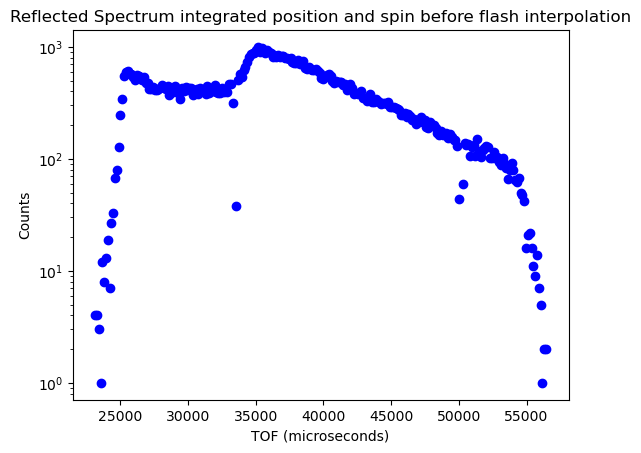

Proton flash detected: 33.44 (ms) (bin = 77)
Proton flash detected: 50.15 (ms) (bin = 202)


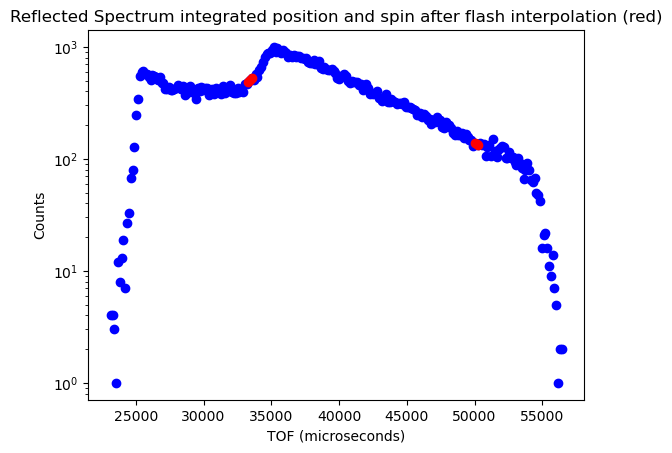

Execution time: 41 seconds


In [137]:
start_time = time.time()
h_prj = np.sum(np.sum(np.sum(e_map,axis=3),axis=1),axis=0)
plt.xlabel('TOF (microseconds)')
plt.ylabel('Counts')
plt.yscale('log')
plt.title('Reflected Spectrum integrated position and spin before flash interpolation')
plt.plot(tof,h_prj, 'bo')
plt.show()

dx = 2 # displacement from from zero, dx points affected on either size of zero

flash_sum = np.sum(np.sum(np.sum(e_map,axis=3),axis=1),axis=0) # A flash will have no sum across detector for a specific tbin
# we do not want to interpolate across proton zeros that occur in the head or tail of the frame.
flash_sum[0:10]=1.
flash_sum[tbins-10:tbins-1]=1.

proton_zeros = np.nonzero(flash_sum == 0)[0] # Detect the tbins
if len(proton_zeros)>= 1:
    for l in range(len(proton_zeros)):
        flash_sum = np.sum(np.sum(np.sum(e_map,axis=3),axis=1),axis=0) 
        if flash_sum[int(proton_zeros[l])] == 0: # check that the gap still exists and wasn't filled yet
            print('Proton flash detected: %.2f (ms) (bin = %s)'%(tof[int(proton_zeros[l])]/1000,int(proton_zeros[l])))
            for k in range(4):
                if active_spin_states[k]:
                    for i in range(n):
                        for j in range(m):
                            # points to the left in tof of the flash
                            x1 = np.arange(int(proton_zeros[l])-3*dx+1,int(proton_zeros[l])-3*dx+1+2*dx,1,dtype=np.int16)
                            y1 = e_map[i,j,x1,k]

                            # points to the right in tof of the flash
                            x2 = np.arange(int(proton_zeros[l])+dx+1,int(proton_zeros[l])+dx+1+2*dx,1,dtype=np.int16)
                            y2 = e_map[i,j,x2,k]

                            x = np.concatenate((x1,x2)) # tof sampled
                            y = np.concatenate((y1,y2)) # data sampled

                            xgap = np.arange(x1[-1]+1,x2[0]-1,1,dtype=np.int16)
                            b = (y[-1]-y[0])/(x[-1]-x[0])
                            a = y[0] - b * x[0]
                        
                            popt, pcov = opt.curve_fit(line, x, y, p0=[a,b]) # fit poly to both sides of gap
                            ygap = line(xgap,*popt)

                            e_map[i,j,xgap,k] = ygap # fill the gap
                            var_e_map[i,j,xgap,k] = 10*ygap # fill the gap, till this point the data and variance same, increase variance by 10x in the gap cause the data interpolated here and not measured.
                        
h_prj = np.sum(np.sum(np.sum(e_map,axis=3),axis=1),axis=0)
v_prj = np.sum(np.sum(np.sum(var_e_map,axis=3),axis=1),axis=0)
plt.xlabel('TOF (microseconds)')
plt.ylabel('Counts')
plt.yscale('log')
plt.title('Reflected Spectrum integrated position and spin after flash interpolation (red)')
plt.plot(tof,h_prj, 'bo')
xgap = np.nonzero(v_prj>h_prj)
plt.plot(tof[xgap],h_prj[xgap], 'ro')
plt.show()

print('Execution time: %.0f seconds' % (time.time() - start_time))

## Find the Region of Interest
Outside the ROI is used to fit a model to the background.

Inside the ROI is signal. The model will estimate the background inside the ROI.

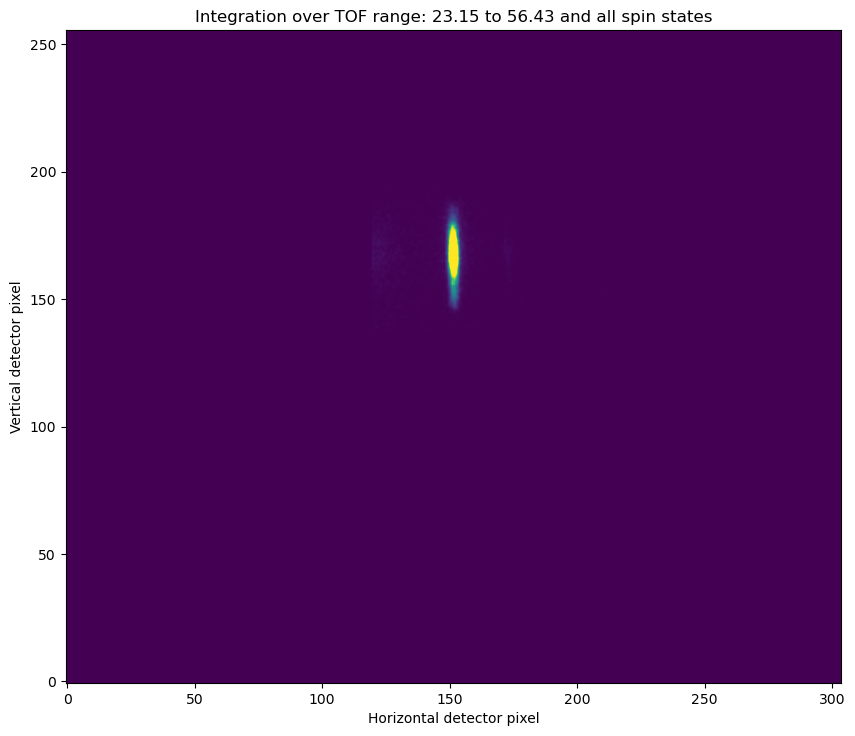

Horizontal limits on shadow mask: 120 250
Peak centroid and rms width (horizontal): 151.51 1.15)
ROI lower and upper horizontal limits: 140 160
Peak centroid and rms width (vertical): 167.68 6.59)
ROI lower and upper vertical limits: 140 205


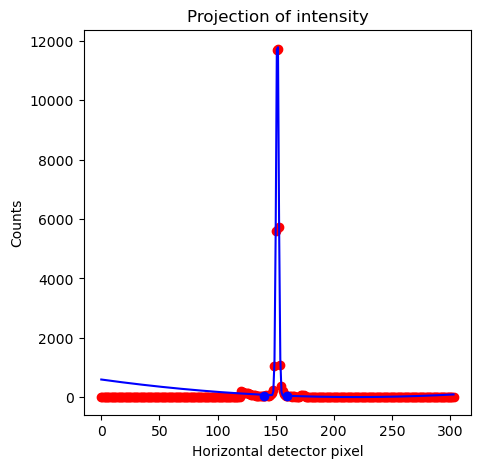

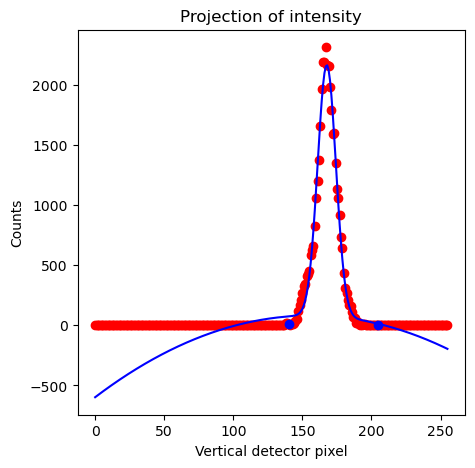

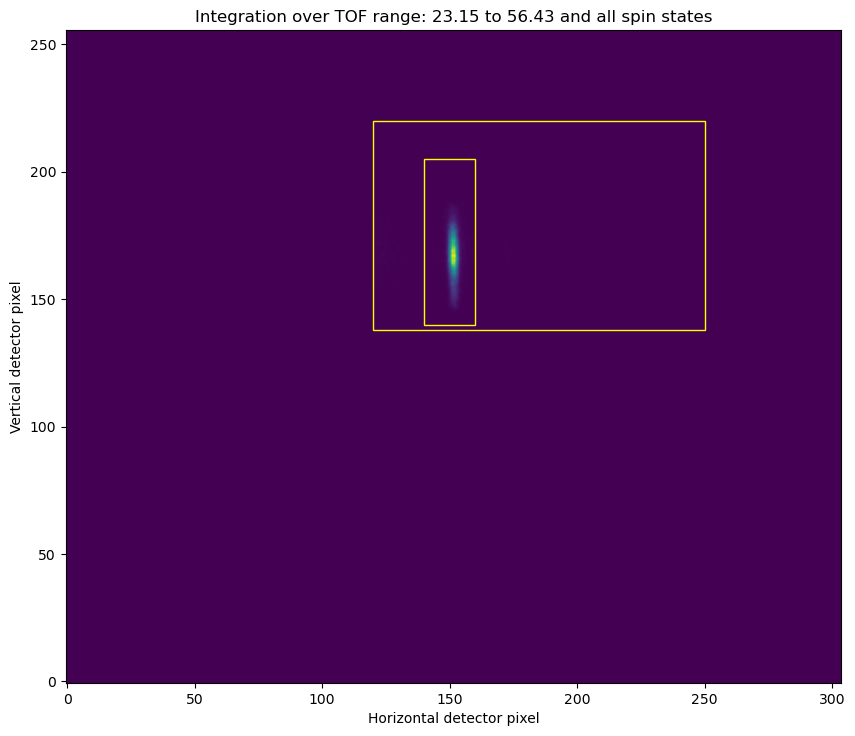

In [138]:
t_range = [tof_min,tof_max] # microseconds range over which to integrate can be changed by user
t_integration = np.zeros([n,m,4], dtype=np.float32) 

a0,i0 = find_nearest(tof,t_range[0])
a1,i1 = find_nearest(tof,t_range[1])

for sdx in range(4):
    t_integration[:,:,sdx]=np.sum(e_map[:,:,i0:i1,sdx],axis=2) # integrate over all time in range
ts_integration = np.sum(t_integration,axis=2) # integrate over all spin states

if shadow_custom: # zero out all intensities outside of hmask and vmask shadow
    ShadowMask = np.zeros((n,m), dtype=np.bool8)
    ShadowMask[hmask_lo_custom:hmask_hi_custom,vmask_lo_custom:vmask_hi_custom] = 1
    ts_integration = ts_integration * ShadowMask

# plot a test image before calculations
# use e_image for plotting an image, otherwise use t_integration and e_map
vmax = np.max(ts_integration)
e_image = ts_integration
plt.figure(figsize = (10,10))
plt.xlabel('Horizontal detector pixel')
plt.ylabel('Vertical detector pixel')
plt.title('Integration over TOF range: %.2f to %.2f and all spin states'%(tof_min/1000,tof_max/1000))
plt.imshow(np.transpose(e_image,axes=[1,0]), origin='lower',interpolation='bilinear', cmap=cm.viridis, norm=colors.Normalize(vmin=0, vmax=vmax/3))
plt.show()

# assemble h-projection and estimate ROI
h_projection = np.zeros(n, dtype=np.float32)
x_index = np.zeros(n,dtype=np.float32)
for i in range(n):
    x_index[i]=i
    for j in range(m):
        h_projection[i] = h_projection[i] + ts_integration[i,j]

if shadow_custom: # this calculates projection over just the custom ROI
    h_projection = np.sum(ts_integration[:,roi_0v_custom:roi_1v_custom],axis=1)
        
# Add some shadow detection at extremes
# in horizontal search from 0 to hlo and from hhi to :
hlo = 30
hhi = n-100
derr = 10
hmask_lo = int(np.max(np.where(np.gradient(h_projection[0:hlo])==np.max(np.gradient(h_projection[0:hlo])))[0]) + hlo + derr)
hmask_hi = int(np.min(np.where(np.gradient(h_projection[hhi:])==np.min(np.gradient(h_projection[hhi:])))[0]) + hhi - derr)

# look for left shadow

h0_std = np.std(h_projection[0:hmask_lo]) #region which may have a shadow
h1_std = np.std(h_projection[hmask_lo:hmask_lo+2*derr]) #region for comparison
left_shadow = False
if h0_std > 2*h1_std:
    left_shadow = True
    print('Possible left-hand (low angle) shadow detected at pixel: %s (sigmas %.2f %.2f)'%(hmask_lo,h0_std,h1_std))
else:
    hmask_lo = 0
    
# look for right shadow

h0_std = np.std(h_projection[hmask_hi:])
h1_std = np.std(h_projection[hmask_hi-2*derr:hmask_hi])
right_shadow = False
if h0_std > 2*h1_std:
    right_shadow = True
    print('Possible right-hand (high angle) shadow detected at pixel: %s (sigmas: %.2f %.2f)'%(hmask_hi,h0_std,h1_std))
else:
    hmask_hi = n-1        

if shadow_custom:
    hmask_lo = hmask_lo_custom
    hmask_hi = hmask_hi_custom
    
print('Horizontal limits on shadow mask: %s %s'%(hmask_lo,hmask_hi))
    
a=np.amax(h_projection[hmask_lo:hmask_hi])
bv,b = find_nearest(h_projection,a)
c=10.
d = 0.
e = 0.
f = 0.
g = n/2.
popt, pcov = opt.curve_fit(gaussian_and_poly, x_index[hmask_lo:hmask_hi], h_projection[hmask_lo:hmask_hi], p0=[a,b,c,d,e,f,g])

centroid = popt[1]
rms_width = popt[2]
# Find c0 along horizontal direction
g,c0h = find_nearest(x_index,centroid)
g0h,roi_0h = find_nearest(x_index,c0h-np.fix(np.abs(rms_width)+0.5)*4)
g1h,roi_1h = find_nearest(x_index,c0h+np.fix(np.abs(rms_width)+0.5)*4)

# ensure ROI is inside shadow mask
roi_0h = np.max([roi_0h,hmask_lo+1])
roi_1h = np.min([roi_1h,hmask_hi-1])

print('Peak centroid and rms width (horizontal): %.2f %.2f)'%(centroid,rms_width))

if shadow_custom:
    roi_0h = roi_0h_custom
    roi_1h = roi_1h_custom

print('ROI lower and upper horizontal limits: %s %s'%(roi_0h,roi_1h))

plt.figure(figsize = (5,5))
plt.xlabel('Horizontal detector pixel')
plt.ylabel('Counts')
plt.title('Projection of intensity')
plt.plot(x_index,h_projection,'ro')
plt.plot(x_index,gaussian_and_poly(x_index, *popt),'b-')
plt.plot(roi_0h,h_projection[roi_0h],'bo')
plt.plot(roi_1h,h_projection[roi_1h],'bo')
plt.show

# assemble v-projection and estimate ROI
v_projection = np.zeros(m, dtype=np.float32)
y_index = np.zeros(m,dtype=np.float32)
for i in range(m):
    y_index[i]=i
    for j in range(n):
        v_projection[i] = v_projection[i] + ts_integration[j,i]
        
if shadow_custom: # this calculates projection over just the custom ROI
    v_projection = np.sum(ts_integration[roi_0h_custom:roi_1h_custom,:],axis=0)


# Add some shadow detection at extremes
# in vertical search from 0 to hlo and from hhi to :
vlo = 30
vhi = m-50
derr = 10
vmask_lo = int(np.max(np.where(np.gradient(v_projection[0:vlo])==np.max(np.gradient(v_projection[0:vlo])))[0]) + vlo + derr)
vmask_hi = int(np.min(np.where(np.gradient(v_projection[vhi:])==np.min(np.gradient(v_projection[vhi:])))[0]) + vhi - derr)

# look for bottom shadow

v0_std = np.std(v_projection[0:vmask_lo])
v1_std = np.std(v_projection[vmask_lo:vmask_lo+2*derr])
bottom_shadow = False
if v0_std > 2*v1_std:
    bottom_shadow = True
    print('Possible bottom shadow detected at pixel: %s (sigmas: %.2f %.2f)'%(vmask_lo,v0_std,v1_std))
else:
    vmask_lo = 0

# look for top shadow

v0_std = np.std(v_projection[vmask_hi:])
v1_std = np.std(v_projection[vmask_hi-2*derr:vmask_hi])
top_shadow = False
if v0_std > 2*v1_std:
    top_shadow = True
    print('Possible top shadow detected at pixel: %s (sigmas: %.2f %.2f)'%(vmask_hi,v0_std,v1_std))
else:
    vmask_hi = m-1        

if shadow_custom:
    vmask_lo = vmask_lo_custom
    vmask_hi = vmask_hi_custom

a=np.amax(v_projection[vmask_lo:vmask_hi])
bv,b = find_nearest(v_projection,a)
c= 20.
d = 0.
e = 0.
f = 0.
g = m/2.

popt, pcov = opt.curve_fit(gaussian_and_poly, y_index[vmask_lo:vmask_hi], v_projection[vmask_lo:vmask_hi], p0=[a,b,c,d,e,f,g])

centroid = popt[1]
rms_width = popt[2]
# Find c0 along the vertical direction
g,c0v = find_nearest(x_index,centroid)
g0v,roi_0v = find_nearest(y_index,c0v-np.fix(np.abs(rms_width)+0.5)*3)
g1v,roi_1v = find_nearest(y_index,c0v+np.fix(np.abs(rms_width)+0.5)*3)

# ensure ROI is inside shadow mask
roi_0v = np.max([roi_0v,vmask_lo+1])
roi_1v = np.min([roi_1v,vmask_hi-1])

print('Peak centroid and rms width (vertical): %.2f %.2f)'%(centroid,rms_width))

if shadow_custom:
    roi_0v = roi_0v_custom
    roi_1v = roi_1v_custom

print('ROI lower and upper vertical limits: %s %s'%(roi_0v,roi_1v))

plt.figure(figsize = (5,5))
plt.xlabel('Vertical detector pixel')
plt.ylabel('Counts')
plt.title('Projection of intensity')
plt.plot(y_index,v_projection,'ro')
plt.plot(y_index,gaussian_and_poly(y_index, *popt),'b-')
plt.plot(roi_0v,v_projection[roi_0v],'bo')
plt.plot(roi_1v,v_projection[roi_1v],'bo')
plt.show

fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.set_xlabel('Horizontal detector pixel')
ax.set_ylabel('Vertical detector pixel')
ax.set_title('Integration over TOF range: %.2f to %.2f and all spin states'%(tof_min/1000,tof_max/1000))
ax.imshow(np.transpose(e_image,axes=[1,0]), origin='lower',interpolation='bilinear', cmap=cm.viridis, norm=colors.Normalize(vmin=0, vmax=vmax))
# show the small roi
left, bottom, width, height = (roi_0h, roi_0v, roi_1h-roi_0h, roi_1v-roi_0v)
rect = plt.Rectangle((left, bottom), width, height,
                     facecolor="none", edgecolor='yellow', linewidth=1.0)
ax.add_patch(rect)
#show the large roi
left, bottom, width, height = (hmask_lo, vmask_lo, hmask_hi-hmask_lo, vmask_hi-vmask_lo)
rect = plt.Rectangle((left, bottom), width, height,
                     facecolor="none", edgecolor='yellow', linewidth=1.0)
ax.add_patch(rect)
plt.show()


## Subtract background
Fit the background to the data outside of the ROI to a simple 2D function.

Use the fit to estimate through interpolation the background under the ROI.

Plot intensity profiles and an image.

In [139]:

e2_map = copy.deepcopy(e_map) # create a copy of e_mat so when we change e2_mat, e_mat does not change.
var_e2_map = copy.deepcopy(var_e_map)

# A spin-independent background will be fitted to e2_map_ssum which is a weighted (by RunChargeRatio) of the 
# contributions from each spin state.

e2_map_ssum = np.sum(e2_map, axis=3) # this is a sum over all cross-sections

mask = np.empty([n,m],dtype=bool)
mask.fill(True)

#set mask periphery to false
border = 12 # The detector appears dead at its periphery
for i in range(border):
    for j in range(m):
        mask[i,j] = False
        mask[n-1-i,j] = False
for j in range(border):
    for i in range(n):
        mask[i,j] = False
        mask[i,m-1-j] = False

#set mask for shadows to false
for j in range(m):
    for i in range(hmask_lo):
        mask[i,j] = False
    for i in range(n-1-hmask_hi):
        mask[i+hmask_hi,j] = False
for i in range(n):
    for j in range(vmask_lo):
        mask[i,j] = False
    for j in range(m-1-vmask_hi):
        mask[i,j+vmask_hi] = False
        
imask = np.zeros((n,m), dtype=np.int8) # this integer mask will later exclude the background mask (but not the ROI mask part)
imask.fill(1)
imask[np.where(mask[:,:]==False)] = 0

# set mask for interior of ROI
for i in range(roi_1h-roi_0h):
    for j in range(roi_1v-roi_0v):
        mask[i+roi_0h,j+roi_0v]=False
                
x,y = np.where(mask[:,:] == True) #  i,j for True
xdata = np.vstack((x.ravel(),y.ravel())) # converts 2 indices to 1D array
bkg_fit = np.zeros((n,m,tbins),dtype=np.float32)

x0 = np.zeros(n*m, dtype=np.int32) #x0,y0 have indices for entire background even under ROI
y0 = np.zeros(n*m, dtype=np.int32)
k = 0
for i in range(n):
    for j in range(m):
        x0[k] = i
        y0[k] = j
        k = k + 1
xdata0 = np.vstack((x0.ravel(),y0.ravel())) # converts 2 indices to 1D array

f_map = e2_map_ssum[x,y,0]
popt = [np.sum(f_map)/len(f_map),0.,0.]
for k in range(tbins):
    f_map = e2_map_ssum[x,y,k]
    # can only accept fixed number of parameters (this case 3), but runs somewhat faster
    initial_guesses = popt
    popt, pcov = opt.curve_fit(linear_surface, xdata, f_map.ravel(), p0=initial_guesses, maxfev = 2000)
    bkg_fit[x0,y0,k] = linear_surface(xdata0, *popt)  # this is background to be subtracted from every spin state
    if use_leastsq:
        initial_guesses = [popt[0],popt[1],popt[2],1e-6,c0h,1e-6,c0v]
        popt_lsq, success = opt.leastsq(errfunc, initial_guesses[:], args=(xdata, f_map.ravel()))
        bkg_fit[x0,y0,k] = func(popt_lsq, xdata0)  # this is background to be subtracted from every spin state

    for i in range(4):
        if active_spin_states[i]==1:
            e2_map[:,:,k,i] = e2_map[:,:,k,i] - bkg_fit[:,:,k]*RunChargeRatio[i]
            var_e2_map[:,:,k,i] = var_e2_map[:,:,k,i] + np.abs(bkg_fit[:,:,k]*RunChargeRatio[i]) #add varinace of background, protect if negative
            
print('Residual, |data - fit|: %.2e'%(np.sum(np.abs(e2_map_ssum[x,y,:]-bkg_fit[x,y,:]))/len(x)/tbins)) # sum of residuals outside ROI
print('Contribution of background to variance is: %.2e /voxol/state'%(np.sum(bkg_fit)/n/m/tbins))

D3_mat = e2_map
var_D3_mat = var_e2_map

# print info to compare integrated ROI content before background subtraction
print('Integral in small ROI before background subtraction for the spin states.')
print('%.2f %.2f %.2f %.2f'%(np.sum(e_map[roi_0h:roi_1h,roi_0v:roi_1v,:,0]),np.sum(e_map[roi_0h:roi_1h,roi_0v:roi_1v,:,1]), \
np.sum(e_map[roi_0h:roi_1h,roi_0v:roi_1v,:,2]),np.sum(e_map[roi_0h:roi_1h,roi_0v:roi_1v,:,3])))
# print info to compare integrated ROI content before background subtraction
print('Integral in small ROI after background subtraction for the spin states.')
print('%.2f %.2f %.2f %.2f'%(np.sum(D3_mat[roi_0h:roi_1h,roi_0v:roi_1v,:,0]),np.sum(D3_mat[roi_0h:roi_1h,roi_0v:roi_1v,:,1]), \
np.sum(D3_mat[roi_0h:roi_1h,roi_0v:roi_1v,:,2]),np.sum(D3_mat[roi_0h:roi_1h,roi_0v:roi_1v,:,3])))


Residual, |data - fit|: 1.59e-03
Contribution of background to variance is: 1.74e-06 /voxol/state
Integral in small ROI before background subtraction for the spin states.
19271.59 19263.59 0.00 0.00
Integral in small ROI after background subtraction for the spin states.
19271.52 19263.52 0.00 0.00


## Show background subtracted results
Show for images integrated over all TOF


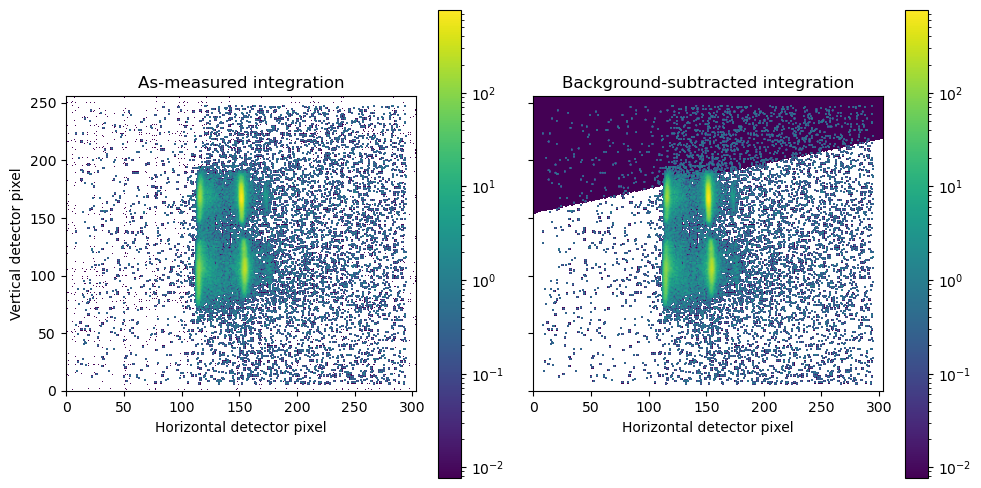

In [140]:
# plot original (left) background subtracted (right)
h_image =  np.sum(np.sum(e_map,axis=3),axis=2) # original data image integrated over all tof and spin states
vmax = np.max(h_image)
g_image =  np.sum(np.sum(e2_map,axis=3),axis=2) # data - background image integrated over all tof and spin states

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), sharey=True)
ax1.set_xlabel('Horizontal detector pixel')
ax1.set_ylabel('Vertical detector pixel')
ax1.set_title('As-measured integration')
im1 = ax1.imshow(np.transpose(h_image,axes=[1,0]), origin='lower',interpolation='bilinear', cmap=cm.viridis, norm=LogNorm(vmin=0.00001*vmax, vmax=vmax))

ax2.set_xlabel('Horizontal detector pixel')
ax2.set_title('Background-subtracted integration')
im2 = ax2.imshow(np.transpose(g_image,axes=[1,0]), origin='lower',interpolation='bilinear', cmap=cm.viridis, norm=LogNorm(vmin=0.00001*vmax, vmax=vmax))

fig.colorbar(im1, ax=ax1, orientation='vertical')
fig.colorbar(im2, ax=ax2, orientation='vertical')
plt.tight_layout()
plt.show()


## Integrate along vertical direction (Qy) of the detector.
Beyond this step GISANS is not supported.

Plot images of the result.

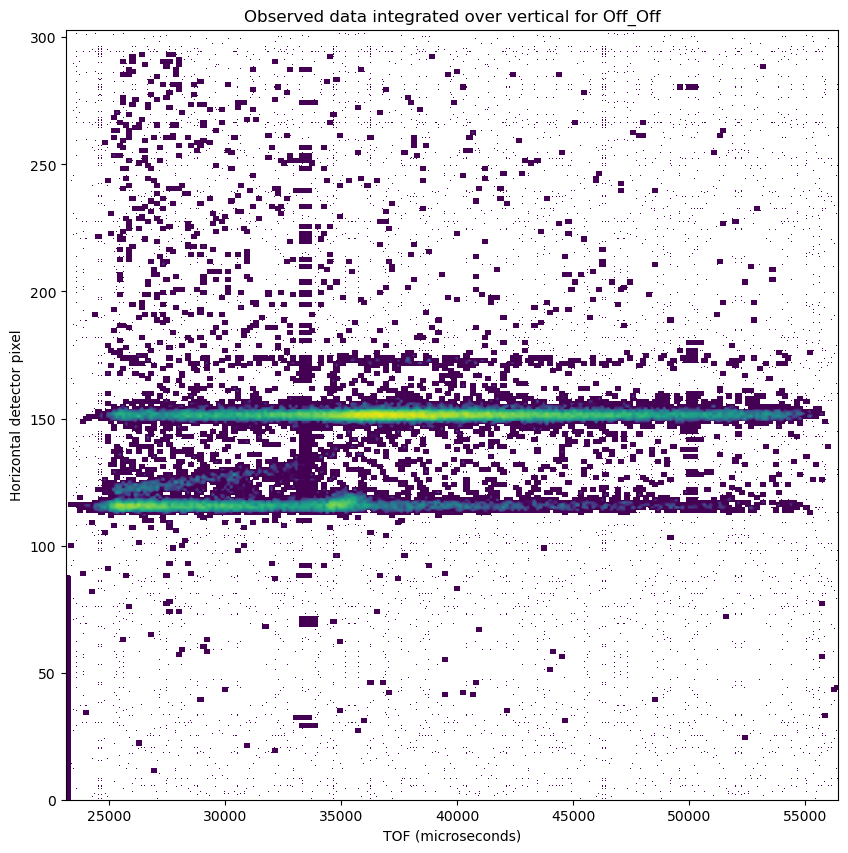

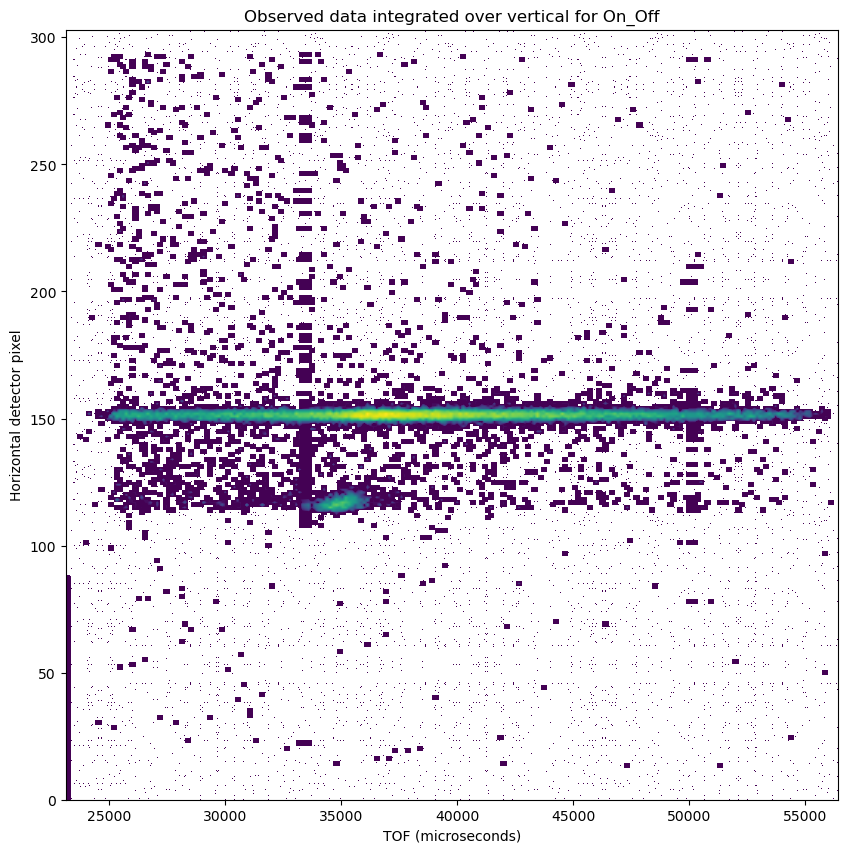

In [141]:
D4_mat = np.sum(D3_mat[:,roi_0v:roi_1v,:,:],axis=1)
var_D4_mat = np.sum(var_D3_mat[:,roi_0v:roi_1v,:,:],axis=1)

vmax = np.max(D4_mat)

for i in range(4):
    if active_spin_states[i]:
        s_state_descriptor = index_to_state(i)
        plt.figure(figsize = (10,10))
        plt.xlabel('TOF (microseconds)')
        plt.ylabel('Horizontal detector pixel')
        plt.title('Observed data integrated over vertical for '+s_state_descriptor)
        plt.imshow(np.transpose(D4_mat[:,:,i],axes=[0,1]), extent=[tof_min,tof_max,0,n-1], aspect=(tof_max-tof_min)/n, origin='lower',interpolation='bilinear', cmap=cm.viridis, norm=LogNorm(vmin=0.01*vmax, vmax=vmax))
        plt.show()


## Get the spectrum data
Include some checks to make sure the observed data and the corresponding spectrum are compatible.

In [142]:
s_all_data, s_all_log = load_some_data(Spectrum_File_Base)

# map to variables
# Only spin states to use are OFF_OFF and possibly ON_OFF.
# The spin flip channels should not be used to acquire the spectrum.
s_active_spin_states = s_all_data[0]
# ensure the SF channels are not used for the spectrum
s_active_spin_states[state_to_index('On_Off')]=0
s_active_spin_states[state_to_index('Off_On')]=0

s_t0_time_Off_Off = s_all_data[1]
s_t0_time_string_Off_Off = s_all_data[2]
s_tof_Off_Off = s_all_data[3]
s_pixel_id_Off_Off = s_all_data[4]
s_pcharge_Off_Off = s_all_data[5]

s_t0_time_On_On = s_all_data[16]
s_t0_time_string_On_On = s_all_data[17]
s_tof_On_On = s_all_data[18]
s_pixel_id_On_On = s_all_data[19]
s_pcharge_On_On = s_all_data[20]   

s_DANGLELog_value= s_all_log[6]
s_DANGLE0Log_value= s_all_log[8]
s_ChopperFreqLog_value= s_all_log[14]
s_LambdaBarLog_value= s_all_log[16]

if np.abs(s_DANGLELog_value[0]+s_DANGLE0Log_value[0]) > 0.01:
    print('WARNING: Detector is not at zero scattering angle: %.2f'%(s_DANGLELog_value[0]+s_DANGLE0Log_value[0]))
if s_ChopperFreqLog_value[0] != ChopperFreqLog_value[0]:
    print('WARNING: Runs: %s and %s use different frequencies.'%(run_number,spectrum_run_number))
if s_LambdaBarLog_value[0] != LambdaBarLog_value[0]:
    print('WARNING: Runs: %s and %s use different wavelength frames.'%(run_number,spectrum_run_number))

Fetching: Off_Off
Fetching: On_Off
No On_Off data found.
Fetching: Off_On
No Off_On data found.
Fetching: On_On
No On_On data found.


## Bin the spectrum data into a 3D matrix

Ensure the binning is done the same way as for the data.

This routine may takes some minutes to run.

In [143]:
# we need to define the SF even though there are no data
s_pixel_id_On_Off = 0
s_pixel_id_Off_On = 0
s_tof_On_Off = 0
s_tof_Off_On = 0
s_bin_data = bin_the_data(n,m,tof_min,tof_max,tbins,s_active_spin_states, \
                        s_pixel_id_Off_Off,s_pixel_id_On_Off,s_pixel_id_Off_On,s_pixel_id_On_On, \
                        s_tof_Off_Off,s_tof_On_Off,s_tof_Off_On,s_tof_On_On)
s_e_map = s_bin_data[1]
var_s_e_map = copy.deepcopy(s_e_map)

## Obtain the ROI for the spectrum

Peak centroid and rms width (horizontal): 151.00 1.41)
ROI lower and upper horizontal limits: 147 155
Peak centroid and rms width (vertical): 130.99 58.15)
ROI lower and upper vertical limits: 0 255


<function matplotlib.pyplot.show(close=None, block=None)>

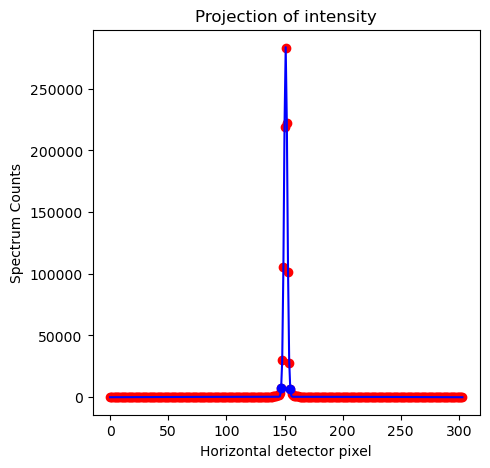

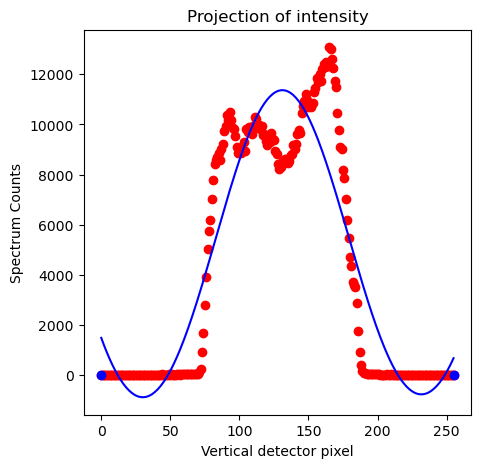

In [144]:
for sdx in range(4):
    t_integration[:,:,sdx]=np.sum(s_e_map[:,:,i0:i1,sdx],axis=2) # integrate over all time in range
ts_integration = np.sum(t_integration,axis=2) # integrate over all spin states

# assemble h-projection and estimate ROI
h_projection = np.zeros(n, dtype=np.float32)
x_index = np.zeros(n,dtype=np.float32)
for i in range(n):
    x_index[i]=i
    for j in range(m):
        h_projection[i] = h_projection[i] + ts_integration[i,j]
    
a = np.amax(h_projection)
bv,b = find_nearest(h_projection,a)
c = 30
d = 0.
e = 0.
f = 0.
g = n/2.
popt, pcov = opt.curve_fit(gaussian_and_poly, x_index, h_projection, p0=[a,b,c,d,e,f,g])

s_centroid = popt[1]
s_rms_width = popt[2]
# Find c0 along horizontal direction
s_g,s_c0h = find_nearest(x_index,s_centroid)
s_g0h,s_roi_0h = find_nearest(x_index,s_c0h-np.fix(s_rms_width+0.5)*4)
s_g1h,s_roi_1h = find_nearest(x_index,s_c0h+np.fix(s_rms_width+0.5)*4)
print('Peak centroid and rms width (horizontal): %.2f %.2f)'%(s_centroid,s_rms_width))
print('ROI lower and upper horizontal limits: %s %s'%(s_roi_0h,s_roi_1h))

plt.figure(figsize = (5,5))
plt.xlabel('Horizontal detector pixel')
plt.ylabel('Spectrum Counts')
plt.title('Projection of intensity')
plt.plot(x_index,h_projection,'ro')
plt.plot(x_index,gaussian_and_poly(x_index, *popt),'b-')
plt.plot(s_roi_0h,h_projection[s_roi_0h],'bo')
plt.plot(s_roi_1h,h_projection[s_roi_1h],'bo')
plt.show

# assemble v-projection and estimate ROI
v_projection = np.zeros(m, dtype=np.float32)
y_index = np.zeros(m,dtype=np.float32)
for i in range(m):
    y_index[i]=i
    for j in range(n):
        v_projection[i] = v_projection[i] + ts_integration[j,i]
    
a = np.amax(v_projection)
bv,b = find_nearest(v_projection,a)
c = 30
d = 0.
e = 0.
f = 0.
g = m/2.
popt, pcov = opt.curve_fit(gaussian_and_poly, y_index, v_projection, p0=[a,b,c,d,e,f,g])

s_centroid = popt[1]
s_rms_width = popt[2]
# Find c0 along the vertical direction
s_g,s_c0v = find_nearest(x_index,s_centroid)
s_g0v,s_roi_0v = find_nearest(y_index,s_c0v-np.fix(s_rms_width+0.5)*3)
s_g1v,s_roi_1v = find_nearest(y_index,s_c0v+np.fix(s_rms_width+0.5)*3)
if s_roi_1v < s_roi_0v:
    s_roi_0v,s_roi_1v = s_roi_1v,s_roi_0v
print('Peak centroid and rms width (vertical): %.2f %.2f)'%(s_centroid,s_rms_width))
print('ROI lower and upper vertical limits: %s %s'%(s_roi_0v,s_roi_1v))

plt.figure(figsize = (5,5))
plt.xlabel('Vertical detector pixel')
plt.ylabel('Spectrum Counts')
plt.title('Projection of intensity')
plt.plot(y_index,v_projection,'ro')
plt.plot(y_index,gaussian_and_poly(y_index, *popt),'b-')
plt.plot(s_roi_0v,v_projection[s_roi_0v],'bo')
plt.plot(s_roi_1v,v_projection[s_roi_1v],'bo')
plt.show


## Create spectrum
Integrate spectrum over all non-spin-flip states.  Typically only Off_Off is provided.

Integrate spectrum over the vertical direction within the ROI.

Determine a range of horizontal pixels that contain useful spectrum. By useful we mean an intensity
greater than s_prct of the maximum of the integral over TOF.

Extract the spectrum, which will consist of a small range of horizontal pixels vs. TOF.

Note that there may be zeros in the spectrum, which will need consideration during normalization.

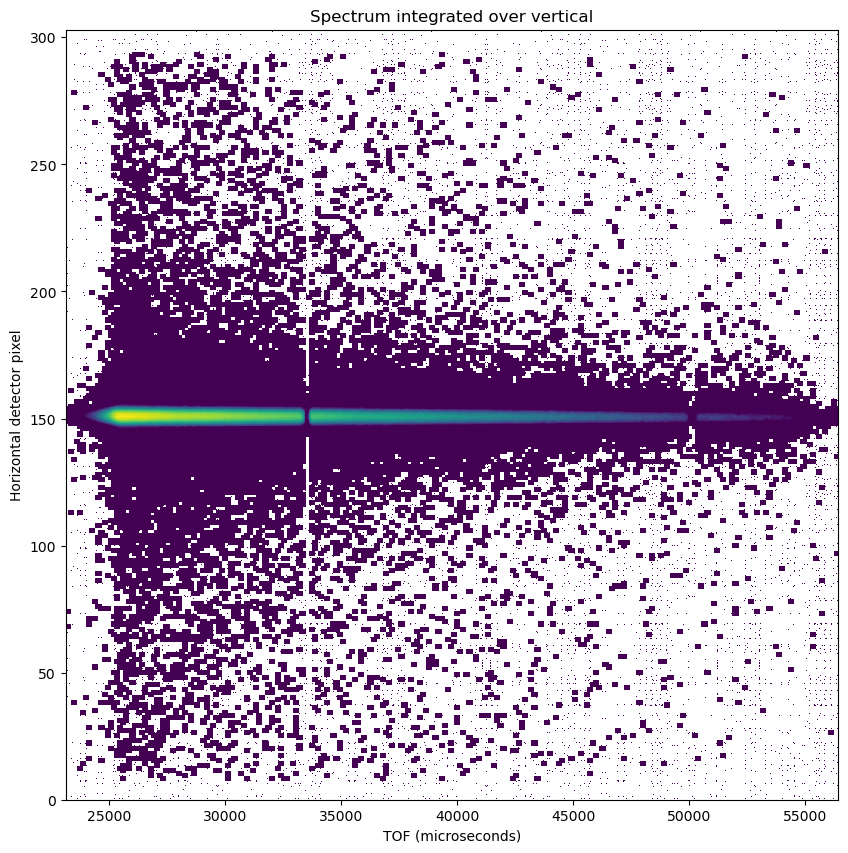

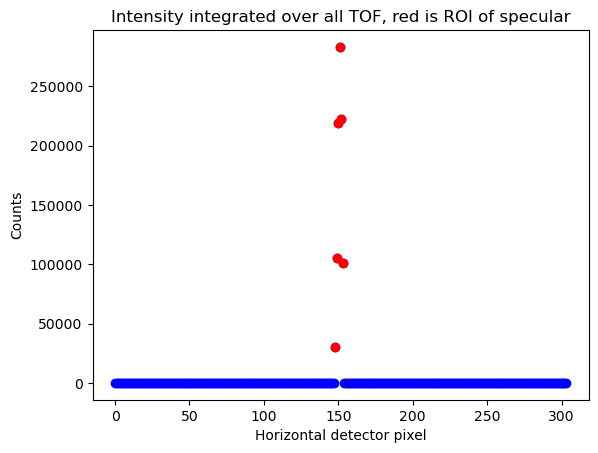

Range of horizontal pixels extracted from data for spectrum: 148 154


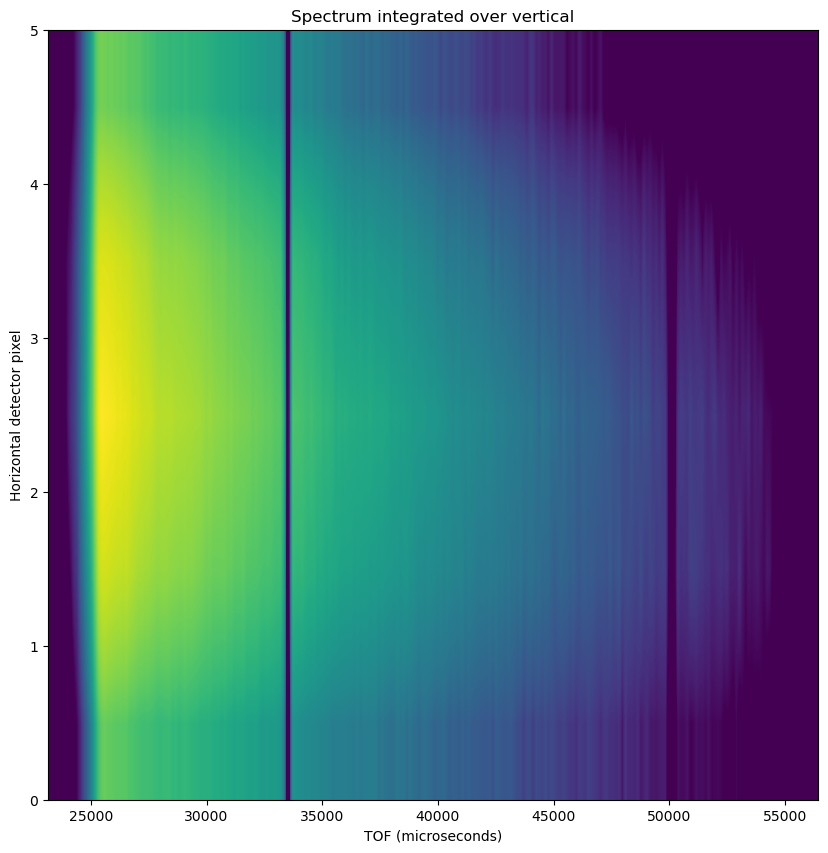

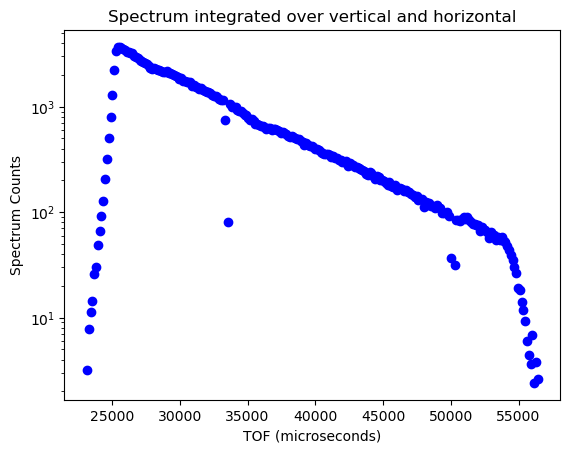

In [145]:
spec_1d = np.sum(np.sum(s_e_map[:,s_roi_0v:s_roi_1v,:,:],axis=3),axis=1) # integrate over all spin states then vertical
var_spec_1d = np.sum(np.sum(var_s_e_map[:,s_roi_0v:s_roi_1v,:,:],axis=3),axis=1) # variance on spec_1d

s_prct = 0.1 # this will be used to find the indices in h having useful intensity

vmax = np.max(spec_1d)

plt.figure(figsize = (10,10))
plt.xlabel('TOF (microseconds)')
plt.ylabel('Horizontal detector pixel')
plt.title('Spectrum integrated over vertical')
plt.imshow(np.transpose(spec_1d,axes=[0,1]), extent=[tof_min,tof_max,0,n-1], aspect=(tof_max-tof_min)/n, origin='lower',interpolation='bilinear', cmap=cm.viridis, norm=LogNorm(vmin=0.01*vmax, vmax=vmax))
plt.show()

sh = np.sum(spec_1d,axis=1)

idx = np.argwhere(sh<s_prct*np.max(sh))
sh[idx] = 0
sh_hi_limit=idx[np.min(np.argwhere(idx[:,0]>s_c0h)),0]
sh_lo_limit=idx[np.max(np.argwhere(idx[:,0]<s_c0h)),0]+1

x=np.zeros(n,dtype=np.float32)
for i in range(n):
    x[i] = i

plt.xlabel('Horizontal detector pixel')
plt.ylabel('Counts')
plt.title('Intensity integrated over all TOF, red is ROI of specular')
plt.plot(x,sh,'bo')
plt.plot(x[sh_lo_limit:sh_hi_limit],sh[sh_lo_limit:sh_hi_limit],'ro')
plt.show()

print('Range of horizontal pixels extracted from data for spectrum: %s %s'%(sh_lo_limit,sh_hi_limit))

spec_1d = spec_1d[sh_lo_limit+1:sh_hi_limit,:]
var_spec_1d = var_spec_1d[sh_lo_limit+1:sh_hi_limit,:]

vmax =  np.max(spec_1d)

plt.figure(figsize = (10,10))
plt.xlabel('TOF (microseconds)')
plt.ylabel('Horizontal detector pixel')
plt.title('Spectrum integrated over vertical')
plt.imshow(np.transpose(spec_1d,axes=[0,1]), extent=[tof_min,tof_max,0,len(spec_1d[:,0])], aspect=(tof_max-tof_min)/len(spec_1d[:,0]), origin='lower',interpolation='bilinear', cmap=cm.viridis, norm=LogNorm(vmin=0.01*vmax, vmax=vmax))
plt.show()

plt.xlabel('TOF (microseconds)')
plt.ylabel('Spectrum Counts')
plt.yscale('log')
plt.title('Spectrum integrated over vertical and horizontal')
plt.plot(tof,np.mean(spec_1d,axis=0), 'bo')
plt.show()

## Fill the proton gap(s) in the spectra
    1) Find the gaps
    2) Fit an interpolate across the gaps
    3) Fill the gap
    4) This routine may takes some minutes to run

Proton flash detected: 33.44 (ms) (bin = 77)
Proton flash detected: 50.15 (ms) (bin = 202)


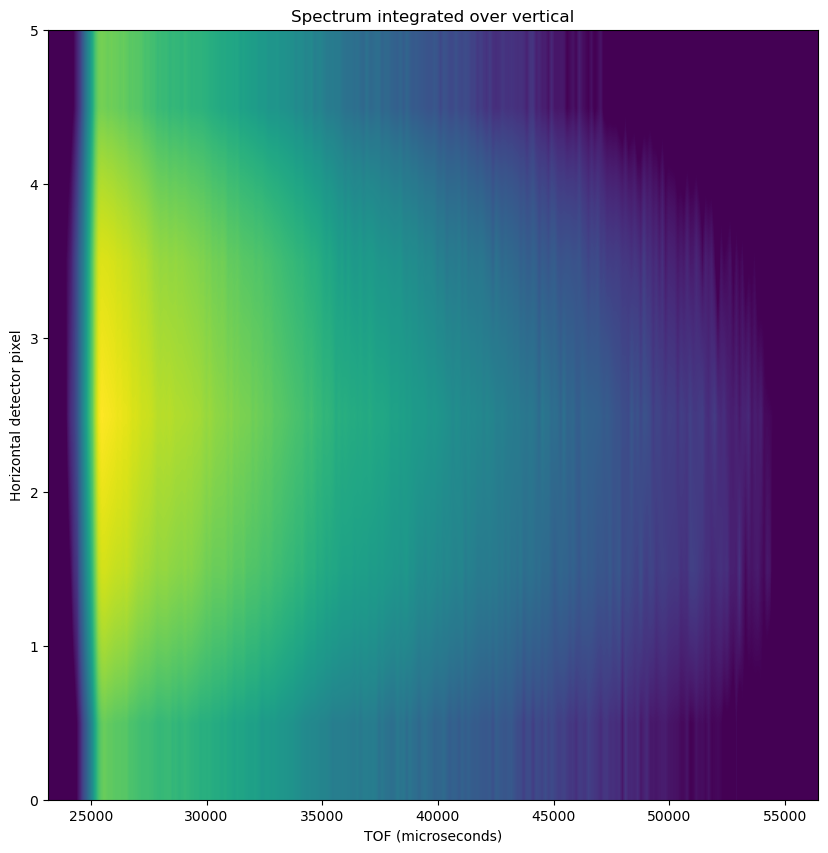

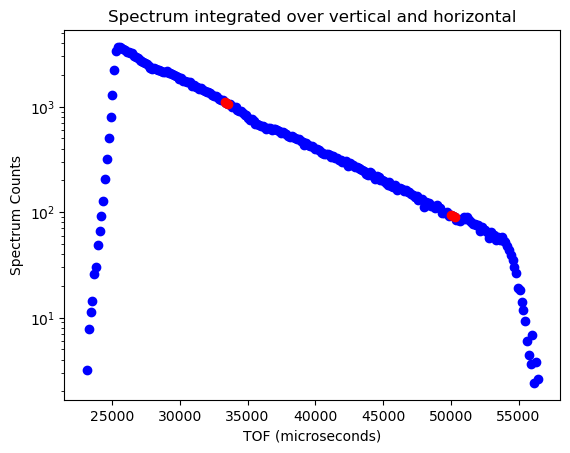

In [146]:
flash_sum = np.sum(np.sum(np.sum(s_e_map,axis=3),axis=1),axis=0) # A flash will have no sum across detector for a specific tbin
proton_zeros = np.nonzero(flash_sum == 0)[0] # Detect the tbins

dx = 2 # displacement from from zero, dx points affected on either size of zero

if len(proton_zeros)>= 1:
    for l in range(len(proton_zeros)):
        if spec_1d[0,int(proton_zeros[l])]==0: # check that the gap still exists and wasn't filled yet
            print('Proton flash detected: %.2f (ms) (bin = %s)'%(tof[int(proton_zeros[l])]/1000,int(proton_zeros[l])))
            for j in range(len(spec_1d[:,0])):
                x1 = np.arange(int(proton_zeros[l])-3*dx+1,int(proton_zeros[l])-3*dx+1+2*dx,1,dtype=np.int16)
                y1 = spec_1d[j,x1]

                x2 = np.arange(int(proton_zeros[l])+dx+1,int(proton_zeros[l])+dx+1+2*dx,1,dtype=np.int16)
                y2 = spec_1d[j,x2]

                x = np.concatenate((x1,x2)) # tof sampled
                y = np.concatenate((y1,y2)) # data sampled

                xgap = np.arange(x1[-1]+1,x2[0]-1,1,dtype=np.int16)

                b = (y[-1]-y[0])/(x[-1]-x[0])
                a = y[0] - b * x[0]
                c = 0.
                if tof[x[0]]/1000 < 45: # for short-medium tof use polynomial of 2nd order
                    popt, pcov = opt.curve_fit(poly, x, y, p0=[a,b,c]) # fit poly to both sides of gap
                    ygap = poly(xgap,*popt)
                else:
                    popt, pcov = opt.curve_fit(line, x, y, p0=[a,b]) # fit poly to both sides of gap
                    ygap = line(xgap,*popt)
                            
                spec_1d[j,xgap] = ygap # fill the gap
                var_spec_1d[j,xgap] = 10*ygap # fill the gap
                
plt.figure(figsize = (10,10))
plt.xlabel('TOF (microseconds)')
plt.ylabel('Horizontal detector pixel')
plt.title('Spectrum integrated over vertical')
plt.imshow(np.transpose(spec_1d,axes=[0,1]), extent=[tof_min,tof_max,0,len(spec_1d[:,0])], aspect=(tof_max-tof_min)/len(spec_1d[:,0]), origin='lower',interpolation='bilinear', cmap=cm.viridis, norm=LogNorm(vmin=0.01*vmax, vmax=vmax))
plt.show()

plt.xlabel('TOF (microseconds)')
plt.ylabel('Spectrum Counts')
plt.yscale('log')
plt.title('Spectrum integrated over vertical and horizontal')
plt.plot(tof,np.mean(spec_1d,axis=0), 'bo')
xgap = np.nonzero(np.mean(var_spec_1d,axis=0)>np.mean(spec_1d,axis=0))
plt.plot(tof[xgap],np.mean(spec_1d,axis=0)[xgap], 'ro')
plt.show()

## Normalize by proton charge.
Normalize run and spectrum data to proton charge.

In [147]:
# The proton charge variable run_charge was obtained immediately after loading the data.
# It was needed earlier in the background subtraction step.

# Obtain the total proton charge accumulated during spectrum acquisition.
# Find the unique t0s, their indices, then sum pcharge over these indices
spec_charge = np.zeros(4, dtype=np.float32) #contains integrated p charge for each spin state for the spectrum

state = 'Off_Off'
sdx = state_to_index(state)
if s_active_spin_states[sdx] == 1:
    u_value,u_idx = np.unique(s_t0_time_Off_Off,return_index=True)
    spec_charge[sdx] = np.sum(s_pcharge_Off_Off[u_idx])
    print('Total accumulated proton charge for spectrum state %s: %s'%(state,spec_charge[sdx]))
        
state = 'On_On'
sdx = state_to_index(state)
if s_active_spin_states[sdx] == 1:
    u_value,u_idx = np.unique(s_t0_time_On_On,return_index=True)
    spec_charge[sdx] = np.sum(s_pcharge_On_On[u_idx])
    print('Total accumulated proton charge for spectrum state %s: %.e2'%(state,spec_charge[sdx]))
    
# spectrum was collapsed to one spin state, so collapse the p-charge for both spin states for the spectrum.
spec_charge = np.sum(spec_charge)

# Normalize run and spectrum data to the univerisal p-charge
D5p_mat = np.zeros((n,tbins,4), dtype=np.float32)
var_D5p_mat = np.zeros((n,tbins,4), dtype=np.float32)

for i in range(4):
    if run_charge[i]!=0:
        D5p_mat[:,:,i] = D4_mat[:,:,i] * (1 / run_charge[i])
        var_D5p_mat[:,:,i] = var_D4_mat[:,:,i] * (1 / run_charge[i])**2
        
spec_1d = spec_1d * (1 / spec_charge)
var_spec_1d = var_spec_1d * (1 / spec_charge)**2

Total accumulated proton charge for spectrum state Off_Off: 641872700000.0


## Normalize by variation of the spectrum with TOF
A complexity is that the TOF-dependence of the spectrum is different depending upon the trajectory of the neutron. In the spectrum image shown previously the TOF-dependence of the top of the spectrum is different than the bottom. The bottom of the spectrum
correspond to trajectories that strike the surface at high angles of incidence and are specularly reflected into the top
of the image of the specular reflectivity. And vice versa for the trajectories illuminating the spectrum image at its top.
Thus for the specular reflectivity we want to normalize the top of its image to the spectrum taken at the bottom of its image.

For the case of off-specular reflectivity, the normalization is less clear.  For regions outside of the specular reflectivity
we will normalize to the average of the spectrum image; as done presently for other analysis codes.

We will treat the specular reflectivity correctly--taking into account the variation of the spectrum with trajectory, but 
use an approximation--or the average--of the spectrum for the region outside the specular reflectivity.

This nuance also impacts the spin-flip scattering analysis for the case when a large magnetic field causes the "specular" 
SF scattering to be displaced from the specular NSF scattering.

    1) Identify the region of interest that closely borders the specular reflectivity.
    2) Within this (specular) ROI, normalize by the spectrum which is mirror reflected about its center detector pixel.
    3) Outside this region, normalize by the average value of the spectrum.

Lower and upper limits of the specular ROI: 143 156


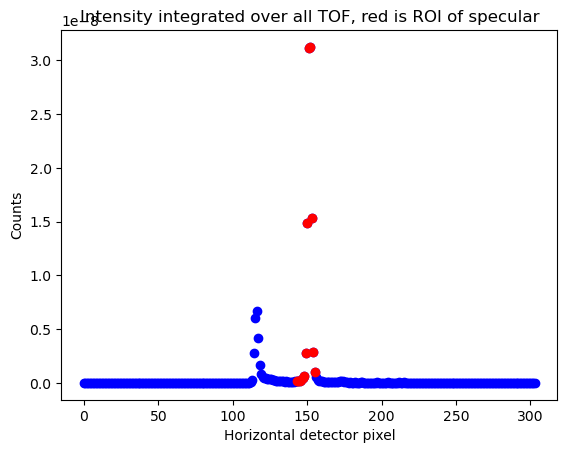

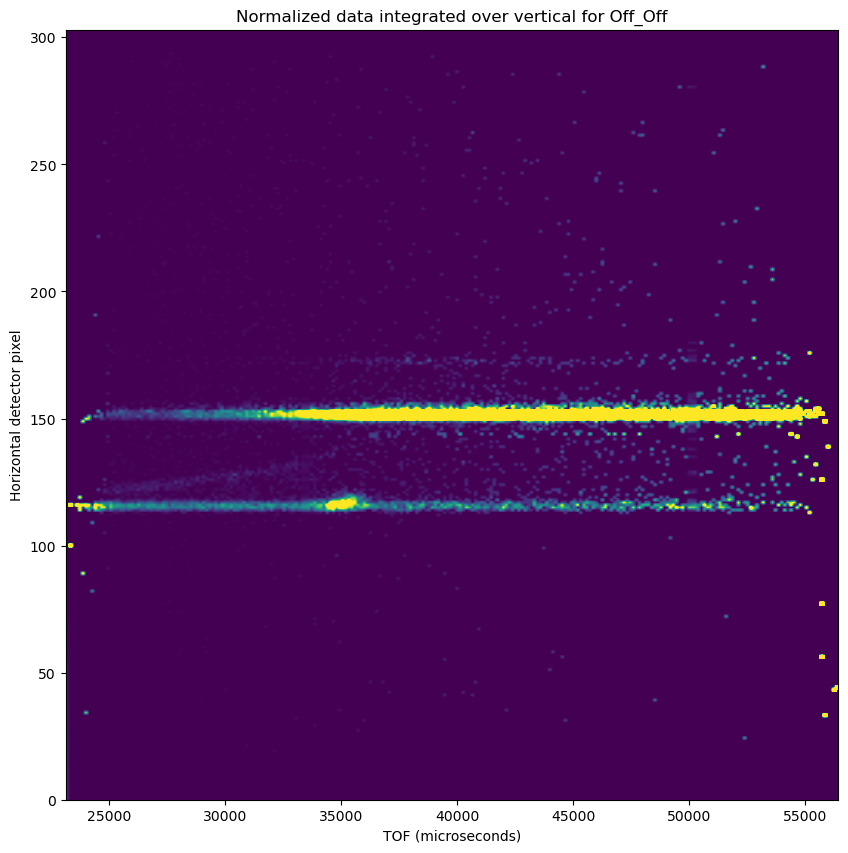

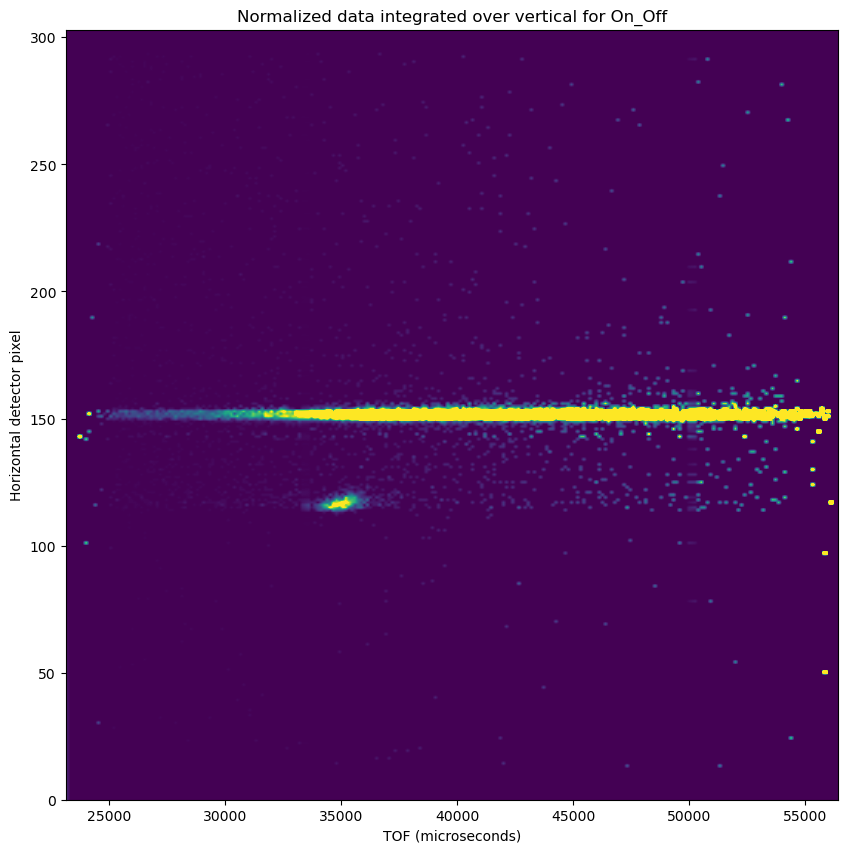

In [148]:
D5_mat = copy.deepcopy(D5p_mat) # this allows us to rerun just this block
var_D5_mat = copy.deepcopy(var_D5p_mat) # variance

x=np.zeros(n,dtype=np.float32)
for i in range(n):
    x[i] = i
    
h_prj = np.sum(np.sum(D5_mat,axis=1),axis=1)

s_prct = 0.075 # this will be used to find the indices in h having useful intensity

idx = np.argwhere(h_prj<s_prct*np.max(h_prj))
sroi_lo_limit=idx[np.max(np.argwhere(idx[:,0]<c0h)),0]
sroi_hi_limit=idx[np.min(np.argwhere(idx[:,0]>c0h)),0]

if tight_custom:
    tight_custom = True
    sroi_lo_limit = roi_0h_tight_custom
    sroi_hi_limit = roi_1h_tight_custom

print('Lower and upper limits of the specular ROI: %s %s'%(sroi_lo_limit,sroi_hi_limit))
plt.xlabel('Horizontal detector pixel')
plt.ylabel('Counts')
plt.title('Intensity integrated over all TOF, red is ROI of specular')
plt.plot(x,h_prj,'bo')
plt.plot(x[sroi_lo_limit:sroi_hi_limit],h_prj[sroi_lo_limit:sroi_hi_limit],'ro')
plt.show()

# pick the sweet spot of spec_1d to calculate its mean
ns = len(spec_1d[:,0])                                            
jlo = int(ns//2-ns/6+0.5)
jhi = int(ns//2+ns/6+0.5)
spec_1d_avg = np.mean(spec_1d[jlo:jhi,:],axis=0) # use for outside of specular roi
var_spec_1d_avg = np.sum(var_spec_1d[jlo:jhi,:],axis=0) / (jhi-jlo+1)**2 # variance on spec_1d_avg

#normalize to spectrum below roi of specular reflectivity with spectrum mean
for i in range(sroi_lo_limit):
    for j in range(4):
        var_D5_mat[i,:,j] = (np.sqrt(var_D5_mat[i,:,j])/D5_mat[i,:,j]+np.sqrt(var_spec_1d_avg)/spec_1d_avg)**2
        D5_mat[i,:,j] = D5_mat[i,:,j] / spec_1d_avg[:]
#        var_D5_mat[i,:,j] = var_D5_mat[i,:,j] / spec_1d_avg[:]**2
        var_D5_mat[i,:,j] = D5_mat[i,:,j]**2*var_D5_mat[i,:,j]
        
#normalize to spectrum above roi of specular reflectivity with spectrum mean
for i in range(n-1-sroi_hi_limit):
    for j in range(4):
        var_D5_mat[i+sroi_hi_limit+1,:,j] = (var_D5_mat[i+sroi_hi_limit+1,:,j]/D5_mat[i+sroi_hi_limit+1,:,j]+\
                                            np.sqrt(var_spec_1d_avg)/spec_1d_avg)**2
        D5_mat[i+sroi_hi_limit+1,:,j] = D5_mat[i+sroi_hi_limit+1,:,j] / spec_1d_avg[:]
#        var_D5_mat[i+sroi_hi_limit+1,:,j] = var_D5_mat[i+sroi_hi_limit+1,:,j] / spec_1d_avg[:]**2
        var_D5_mat[i+sroi_hi_limit+1,:,j] = D5_mat[i+sroi_hi_limit+1,:,j]**2*var_D5_mat[i+sroi_hi_limit+1,:,j]

#normalize to spectrum in roi of specular reflectivity
                                            
for i in range(sroi_hi_limit-sroi_lo_limit+1):
    h = int(i + sroi_lo_limit)
    s_idx_map = int(ns-1 - (h-sroi_lo_limit)/(sroi_hi_limit-sroi_lo_limit)*ns + 0.5)
    for j in range(4):
        var_D5_mat[h,:,j] = (np.sqrt(var_D5_mat[h,:,j])/D5_mat[h,:,j]+np.sqrt(var_spec_1d[s_idx_map,:])/spec_1d[s_idx_map,:])**2 
        D5_mat[h,:,j] = D5_mat[h,:,j] / spec_1d[s_idx_map,:] 
#        var_D5_mat[h,:,j] = var_D5_mat[h,:,j] / spec_1d[s_idx_map,:]**2 
        var_D5_mat[h,:,j] = D5_mat[h,:,j]**2*var_D5_mat[h,:,j] 

# Ensure zeros of spectrum are also excluded in data
idx = np.argwhere(spec_1d_avg==0)
D5_mat[:,idx,:] = 0.
var_D5_mat[:,idx,:] = 0.

# deal with divide by zeros
D5_mat[np.isnan(D5_mat)]=0.
D5_mat[np.isinf(D5_mat)]=0.
var_D5_mat[np.isnan(var_D5_mat)]=0.
var_D5_mat[np.isinf(var_D5_mat)]=0.

vmax=np.sum(np.sum(np.sum(np.abs(D5_mat[sroi_lo_limit:sroi_hi_limit,:,:]),axis=1),axis=1),axis=0)/tbins/len(np.argwhere(active_spin_states == 1))/(sroi_hi_limit-sroi_lo_limit)

for i in range(4):
    if active_spin_states[i]==1:
        s_state_descriptor = index_to_state(i)
        plt.figure(figsize = (10,10))
        plt.xlabel('TOF (microseconds)')
        plt.ylabel('Horizontal detector pixel')
        plt.title('Normalized data integrated over vertical for '+s_state_descriptor)
        plt.imshow(np.transpose(D5_mat[:,:,i],axes=[0,1]), extent=[tof_min,tof_max,0,n-1], aspect=(tof_max-tof_min)/n, origin='lower',interpolation='bilinear', cmap=cm.viridis, norm=colors.Normalize(vmin=0, vmax=vmax))
#        plt.imshow(np.transpose(D5_mat[:,:,i],axes=[0,1]), extent=[tof_min,tof_max,0,n-1], aspect=(tof_max-tof_min)/n, origin='lower',interpolation='bilinear', cmap=cm.viridis, norm=LogNorm(vmin=0.00001*vmax, vmax=vmax/10))
        plt.show()


## Apply polarization and flipping efficiency corrections
The notebook 'efficiency_calculations' should already have been run to extract the efficiencies of the front and back polarizers and flippers. The notebook provides the parameters of an n=3 polynomial fit to the efficiencies measured as a function of wavelength(!).

Fetching: /Users/pookie/JNUpdates/27527/Efficiencies.npz


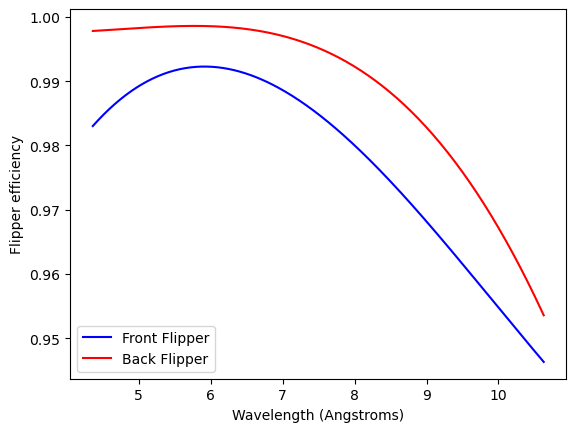

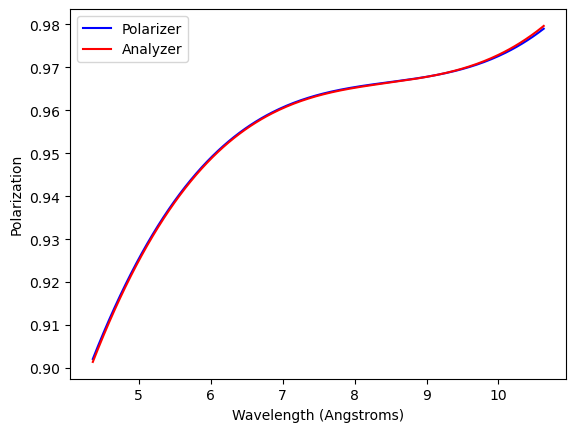

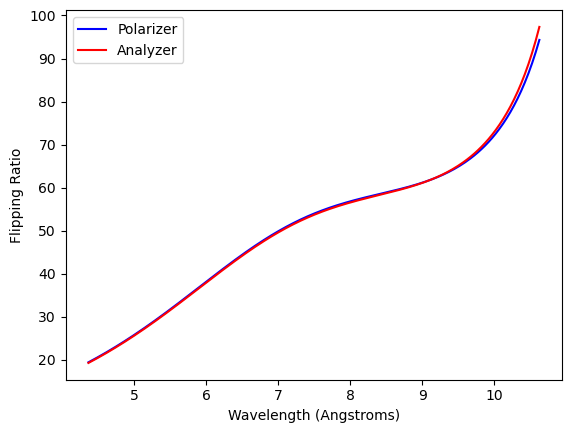

Uncertainties in flipper and polarizer efficiencies increase the variance from: 1.203E+01 to 1.206E+01


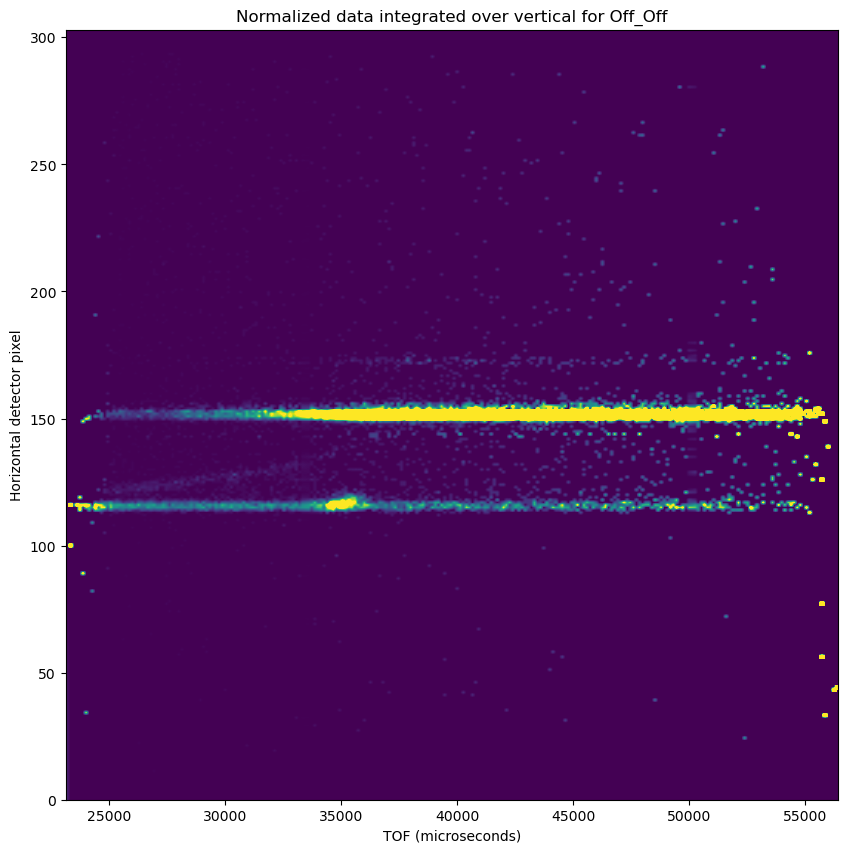

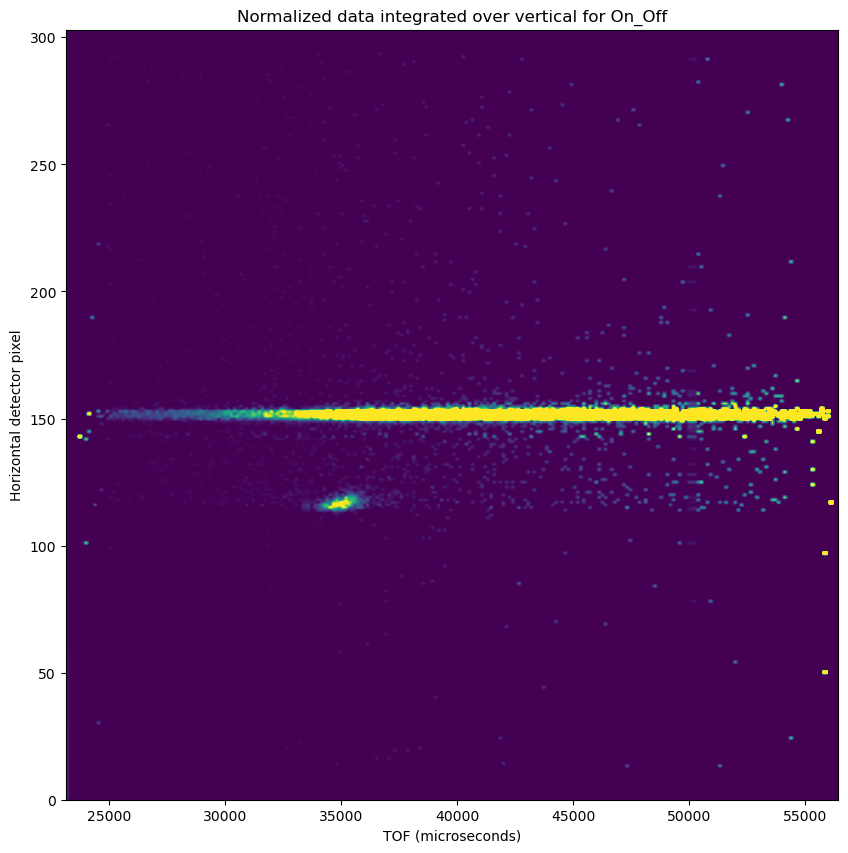

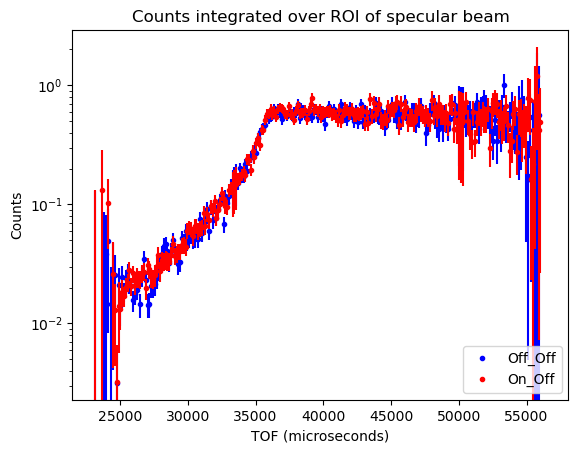

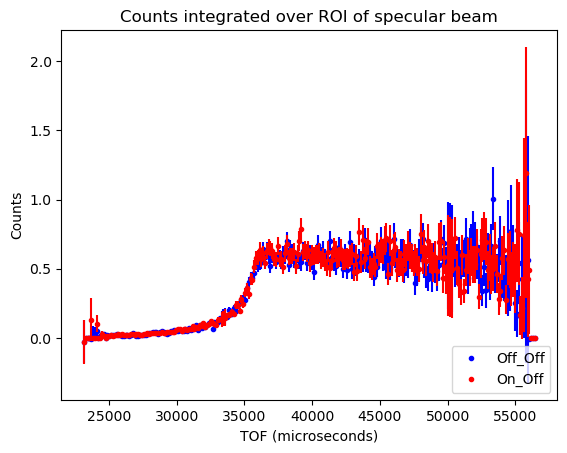

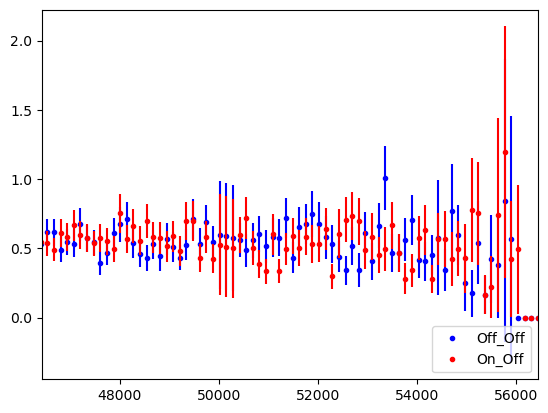

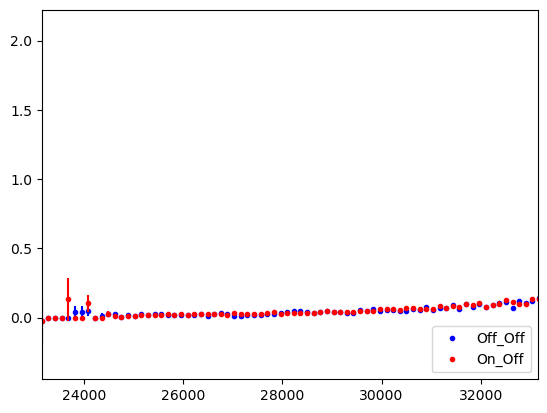

In [149]:
D6_mat = copy.deepcopy(D5_mat)
var_D6_mat = copy.deepcopy(var_D5_mat) # variance is not yet modified by efficiency corrections!

nspin_states = len(np.argwhere(active_spin_states == 1))

if nspin_states>1:

    Pfn = directory_path+'Efficiencies.npz'
    try:
        print('Fetching: %s'%Pfn)
        data = np.load(Pfn)
        e_p = data['arr_0']
        f_p = data['arr_1']
        p1_p = data['arr_2']
        p2_p = data['arr_3']
# the efficiencies were calculated using wavelength as independent variable.
        L = 3956. * tof/1e6 / (Source_Sample_Distance+Sample_Detector_Center_Distance)
        e_fit = np.polyval(e_p,L)
        f_fit = np.polyval(f_p,L)
        p1_fit = np.polyval(p1_p,L)
        p2_fit = np.polyval(p2_p,L)
    except IOError:
        print('No polarization and flipper efficiency file found. Assuming near perfection.')
        L = 3956. * tof/1e6 / (Source_Sample_Distance+Sample_Detector_Center_Distance)
        e_fit = np.empty(tbins)
        e_fit.fill(0.99999)
        f_fit = np.empty(tbins)
        f_fit.fill(0.99999)
        p1_fit = np.empty(tbins)
        p1_fit.fill(0.99999)
        p2_fit = np.empty(tbins)
        p2_fit.fill(0.99999)

    F1_fit = (p1_fit+1.)/(1.-p1_fit) # flipping ratios
    F2_fit = (p2_fit+1.)/(1.-p2_fit)

    plt.yscale('linear')
    plt.xlabel('Wavelength (Angstroms)')
    plt.ylabel('Flipper efficiency')
    plt.plot(L,e_fit,'b', label='Front Flipper')
    plt.plot(L,f_fit,'r', label='Back Flipper')
    plt.legend(loc='lower left')
    plt.show() 

    plt.yscale('linear')
    plt.xlabel('Wavelength (Angstroms)')
    plt.ylabel('Polarization')
    plt.plot(L,p1_fit,'b',label='Polarizer')
    plt.plot(L,p2_fit,'r',label='Analyzer')
    plt.legend(loc='upper left')
    plt.show() 

    plt.yscale('linear')
    plt.xlabel('Wavelength (Angstroms)')
    plt.ylabel('Flipping Ratio')
    plt.plot(L,F1_fit,'b',label='Polarizer')
    plt.plot(L,F2_fit,'r',label='Analyzer')
    plt.legend(loc='upper left')
    plt.show() 

    if nspin_states == 4: # used polarization analyzer
        for i in range(tbins):
            n_mat = get_n_with_pa(e_fit[i],f_fit[i],F1_fit[i],F2_fit[i])
            n_mat_inv = inv(n_mat)
            for j in range(n):
                m_obs = [D6_mat[j,i,0],D6_mat[j,i,1],D6_mat[j,i,2],D6_mat[j,i,3]]
                s = np.dot(n_mat_inv,m_obs)
                D6_mat[j,i,:] = [s[0,0],s[0,1],s[0,2],s[0,3]]

    if nspin_states == 2: # no polarization analysis, offoff and onoff
        for i in range(tbins):
            n_mat = get_n_no_pa(e_fit[i],F1_fit[i])
            n_mat_inv = inv(n_mat)
            for j in range(n):
                m_obs = [D6_mat[j,i,0],D6_mat[j,i,1]]
                s = np.dot(n_mat_inv,m_obs)
                D6_mat[j,i,:] = [s[0,0],s[0,1],0.,0.]
            
# if efficiency file found obtain an uncertainty associated with error on efficiencies
    if IOError:
        de = 0.1 # these are relative errors for e,f,F1 and F2
        df = 0.05
        dF1 = 0.01
        dF2 = 0.01
    
        if nspin_states == 4: # no polarization analysis, offoff and onoff
            p=[[1,0,0,0],[-1,0,0,0],\
               [0,1,0,0],[0,-1,0,0],\
               [0,0,1,0],[0,0,-1,0],\
               [0,0,0,1],[0,0,0,-1],\
               [0,0,0,0]]
            err_mat = np.zeros((n,tbins,4,len(p)), dtype=np.float32) #last index is case index
            for case in range(len(p)):
                p0,p1,p2,p3 = p[case]
                for i in range(tbins):
                    n_mat = get_n_with_pa(e_fit[i]*(1+p0*de),f_fit[i]*(1+p1*df),F1_fit[i]*(1+p2*dF1),F2_fit[i]*(1+p3*dF2))
                    n_mat_inv = inv(n_mat)
                    for j in range(n):
                        m_obs = [D5_mat[j,i,0],D5_mat[j,i,1],D5_mat[j,i,2],D5_mat[j,i,3]]
                        s = np.dot(n_mat_inv,m_obs)
                        err_mat[j,i,:,case] = [s[0,0],s[0,1],s[0,2],s[0,3]]
                    
            for i in range(tbins):
                for j in range(n):
                    for k in range(4):
                        var_D6_mat[j,i,k] = var_D6_mat[j,i,k] + np.var(err_mat[j,i,k,:])
    
        if nspin_states == 2: # no polarization analysis, offoff and onoff
            p=[[1,0],[-1,0],[0,0],[0,1],[0,-1]]
            err_mat = np.zeros((n,tbins,4,len(p)), dtype=np.float32) #last index is case index
            for case in range(len(p)):
                p0,p1 = p[case]
                for i in range(tbins):
                    n_mat = get_n_no_pa(e_fit[i]*(1+p0*de),F1_fit[i]*(1+p1*dF1))
                    n_mat_inv = inv(n_mat)
                    for j in range(n):
                        m_obs = [D5_mat[j,i,0],D5_mat[j,i,1]]
                        s = np.dot(n_mat_inv,m_obs)
                        err_mat[j,i,:,case] = [s[0,0],s[0,1],0.,0.]
                    
            for i in range(tbins):
                for j in range(n):
                    for k in range(2):
                        var_D6_mat[j,i,k] = var_D6_mat[j,i,k] + np.var(err_mat[j,i,k,:])

        print('Uncertainties in flipper and polarizer efficiencies increase the variance from: %.3E to %.3E'%(np.sum(var_D5_mat),np.sum(var_D6_mat)))

#vmax=np.sum(np.sum(np.sum(D6_mat[sroi_lo_limit:sroi_hi_limit,:,:],axis=1),axis=1),axis=0)/tbins/len(np.argwhere(active_spin_states == 1))/(sroi_hi_limit-sroi_lo_limit)
vmax=np.sum(np.sum(np.sum(np.abs(D6_mat[sroi_lo_limit:sroi_hi_limit,:,:]),axis=1),axis=1),axis=0)/tbins/len(np.argwhere(active_spin_states == 1))/(sroi_hi_limit-sroi_lo_limit)

for i in range(4):
    if active_spin_states[i]:
        s_state_descriptor = index_to_state(i)
        plt.figure(figsize = (10,10))
        plt.xlabel('TOF (microseconds)')
        plt.ylabel('Horizontal detector pixel')
        plt.title('Normalized data integrated over vertical for '+s_state_descriptor)
        plt.imshow(np.transpose(D6_mat[:,:,i],axes=[0,1]), extent=[tof_min,tof_max,0,n-1], aspect=(tof_max-tof_min)/n, origin='lower',interpolation='bilinear', cmap=cm.viridis, norm=colors.Normalize(vmin=0, vmax=vmax))
#        plt.imshow(np.transpose(D6_mat[:,:,i],axes=[0,1]), extent=[tof_min,tof_max,0,n-1], aspect=(tof_max-tof_min)/n, origin='lower',interpolation='bilinear', cmap=cm.viridis, norm=LogNorm(vmin=0.00001*vmax, vmax=vmax/10))
        plt.show()

h_prj = np.zeros((tbins,4), dtype=np.float32)
var_h_prj = np.zeros((tbins,4), dtype=np.float32)

for i in range(tbins):
    for j in range(4):
        h_prj[i,j] = np.sum(D6_mat[sroi_lo_limit:sroi_hi_limit,i,j],axis=0)
        var_h_prj[i,j] = np.sum(var_D6_mat[sroi_lo_limit:sroi_hi_limit,i,j],axis=0)

std_h_prj = np.sqrt(var_h_prj)
        
plt.xlabel('TOF (microseconds)')
plt.ylabel('Counts')
plt.yscale('log')
plt.title('Counts integrated over ROI of specular beam')
c  = ['b','r','g','y']
cm1 = [c[0]+'.',c[1]+'.',c[2]+'.',c[3]+'.']
for j in range(4):
    x = np.nonzero(std_h_prj[:,j]<1000.) # plot only values that have not been interpolated as indicated in std dev.
    if active_spin_states[j]==1:
        Atemp = tof[x]
        Btemp = h_prj[:,j]
        Btemp = Btemp[x]
        Ctemp = std_h_prj[:,j]
        Ctemp = Ctemp[x]
        plt.plot(Atemp,Btemp, cm1[j], label=index_to_state(j))
        herr = std_h_prj[x,j]
        plt.errorbar(Atemp,Btemp,yerr=Ctemp,fmt='none',ecolor=c[j])
plt.legend(loc='lower right')
plt.show()

plt.xlabel('TOF (microseconds)')
plt.ylabel('Counts')
plt.title('Counts integrated over ROI of specular beam')
c  = ['b','r','g','y']
cm1 = [c[0]+'.',c[1]+'.',c[2]+'.',c[3]+'.']
for j in range(4):
    x = np.nonzero(std_h_prj[:,j]<1000.) # plot only values that have not been interpolated as indicated in std dev.
    if active_spin_states[j]==1:
        Atemp = tof[x]
        Btemp = h_prj[:,j]
        Btemp = Btemp[x]
        Ctemp = std_h_prj[:,j]
        Ctemp = Ctemp[x]
        plt.plot(Atemp,Btemp, cm1[j], label=index_to_state(j))
        herr = std_h_prj[x,j]
        plt.errorbar(Atemp,Btemp,yerr=Ctemp,fmt='none',ecolor=c[j])
plt.legend(loc='lower right')
plt.show()

plt.xlim(np.max(tof)-10000,np.max(tof))
for j in range(4):
    x = np.nonzero(std_h_prj[:,j]<1000.) # plot only values that have not been interpolated as indicated in std dev.
    if active_spin_states[j]==1:
        Atemp = tof[x]
        Btemp = h_prj[:,j]
        Btemp = Btemp[x]
        Ctemp = std_h_prj[:,j]
        Ctemp = Ctemp[x]
        plt.plot(Atemp,Btemp, cm1[j], label=index_to_state(j))
        herr = std_h_prj[x,j]
        plt.errorbar(Atemp,Btemp,yerr=Ctemp,fmt='none',ecolor=c[j])
plt.legend(loc='lower right')
plt.show()

plt.xlim(np.min(tof),np.min(tof)+10000)
for j in range(4):
    x = np.nonzero(std_h_prj[:,j]<1000.) # plot only values that have not been interpolated as indicated in std dev.
    if active_spin_states[j]==1:
        Atemp = tof[x]
        Btemp = h_prj[:,j]
        Btemp = Btemp[x]
        Ctemp = std_h_prj[:,j]
        Ctemp = Ctemp[x]
        plt.plot(Atemp,Btemp, cm1[j], label=index_to_state(j))
        herr = std_h_prj[x,j]
        plt.errorbar(Atemp,Btemp,yerr=Ctemp,fmt='none',ecolor=c[j])
plt.legend(loc='lower right')
plt.show()


## Write the results to the output file.
Include information in a format required by Qz-binning routines.

In [150]:
a = 0
b = tbins-1
small_tbins = b - a
if tof_user:
    u,a = find_nearest(tof,tof_min_user)
    u,b = find_nearest(tof,tof_max_user)
    small_tbins = b - a

# Create Qz-binning compatible matrix
if len(np.argwhere(active_spin_states==1))==2:
    psd_w_spin_up = np.transpose(D6_mat[:,a:b,state_to_index('Off_Off')])
    psd_w_spin_dw = np.transpose(D6_mat[:,a:b,state_to_index('On_Off')])
    var_psd_w_spin_up = np.transpose(var_D6_mat[:,a:b,state_to_index('Off_Off')])
    var_psd_w_spin_dw = np.transpose(var_D6_mat[:,a:b,state_to_index('On_Off')])
else:
    psd_w_spin_up = np.transpose(D6_mat[:,a:b,state_to_index('Off_Off')])
    psd_w_spin_dwup = np.transpose(D6_mat[:,a:b,state_to_index('On_Off')])
    psd_w_spin_updw = np.transpose(D6_mat[:,a:b,state_to_index('Off_On')])
    psd_w_spin_dw = np.transpose(D6_mat[:,a:b,state_to_index('On_On')])
    var_psd_w_spin_up = np.transpose(var_D6_mat[:,a:b,state_to_index('Off_Off')])
    var_psd_w_spin_dwup = np.transpose(var_D6_mat[:,a:b,state_to_index('On_Off')])
    var_psd_w_spin_updw = np.transpose(var_D6_mat[:,a:b,state_to_index('Off_On')])
    var_psd_w_spin_dw = np.transpose(var_D6_mat[:,a:b,state_to_index('On_On')])

# Need tof array in seconds
tof_w = tof[a:b]/1.e6
# Create two_theta array
# the coordinates from pixel-to-coordinate are: z [m], psi (in scattering plane) [radians], phi [radians]
dbp = n-int(C0Log_value[0]) # horizontal pixel the direct beam illuminates when DANGLE=0 and reversed 4A to python code
two_theta = np.zeros(n, dtype=np.float32)
z,psi,phi = pixel_to_coordinate[dbp*m+c0v,:] #scattering angle within detector
tth_off = psi

for i in range(304):
    z,psi,phi = pixel_to_coordinate[i*m+c0v,:]
    two_theta[i] = (psi - tth_off)
    
DangleMean = np.mean(DANGLELog_value)
DangleMedian = np.median(DANGLELog_value)
DangleStd = np.std(DANGLELog_value)

if DangleStd/DangleMean > 0.01:
    print('Warning: TwoTheta alignment (motion during scan) issue detected.')

print('TwoTheta (mean, median, sigma, last: %.3f %.3f %.3f %.3f)'%(DangleMean,DangleMedian,DangleStd,DANGLELog_value[-1]))
    
two_theta = two_theta + DANGLELog_value[-1]/180.*Pi # Check whether DANGLE+DANGLE0 for liz no

l_mod_sample = Source_Sample_Distance # moderator to sample (meters)
l_sample_det = Sample_Detector_Center_Distance #sample to detector (meters), could be z for tth_off but differ very little (ppm)
l_mod_det = l_mod_sample + l_sample_det #moderator to detector (meters)

#if not MAGH: # need to add for MAGH is true
#    b_induction = EMagLog_value[0] # B in Tesla
    
# Write the results
if len(np.argwhere(active_spin_states==1))==2:
    np.savez(Output_File_Base+'.npz',tbins=small_tbins,n=n,tof_w=tof_w,two_theta=two_theta,\
             l_mod_sample=l_mod_sample,l_sample_det=l_sample_det,\
             l_mod_det=l_mod_det,b_induction=b_induction,\
             psd_w_spin_up=psd_w_spin_up,var_psd_w_spin_up=var_psd_w_spin_up,\
             psd_w_spin_dw=psd_w_spin_dw,var_psd_w_spin_dw=var_psd_w_spin_dw)
else:
    np.savez(Output_File_Base+'.npz',tbins=small_tbins,n=n,tof_w=tof_w,two_theta=two_theta,\
             l_mod_sample=l_mod_sample,l_sample_det=l_sample_det,\
             l_mod_det=l_mod_det,b_induction=b_induction,\
             psd_w_spin_up=psd_w_spin_up,var_psd_w_spin_up=var_psd_w_spin_up,\
             psd_w_spin_dw=psd_w_spin_dw,var_psd_w_spin_dw=var_psd_w_spin_dw,\
             psd_w_spin_dwup=psd_w_spin_dwup,var_psd_w_spin_dwup=var_psd_w_spin_dwup,\
             psd_w_spin_updw=psd_w_spin_updw,var_psd_w_spin_updw=var_psd_w_spin_updw,\
            )


TwoTheta (mean, median, sigma, last: 0.944 1.002 0.115 1.002)


## Show image with scattering angle axis

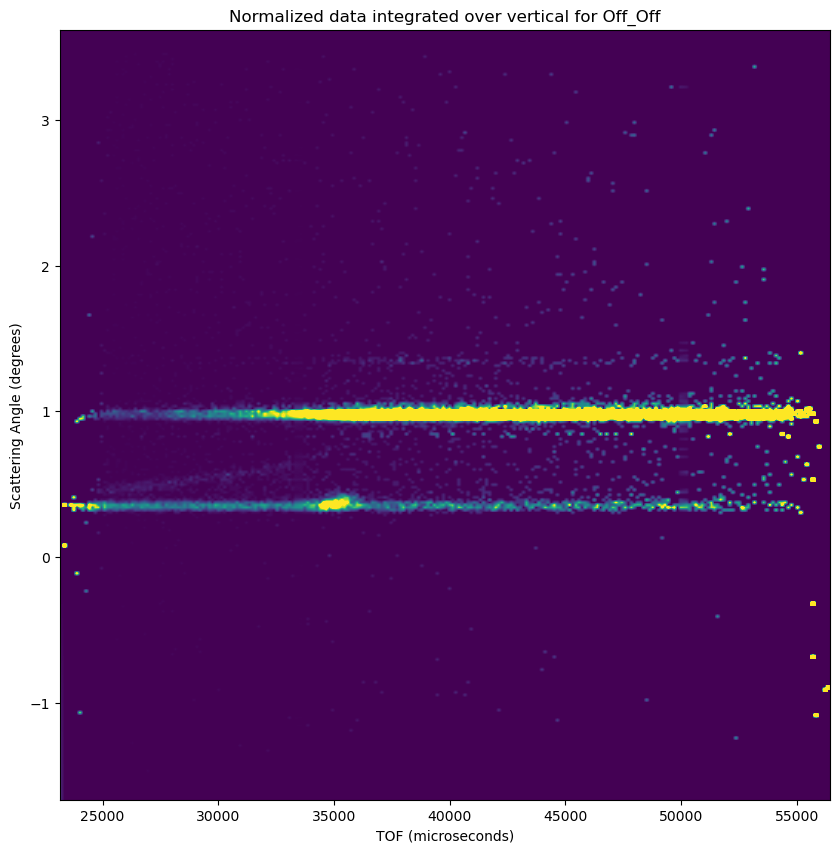

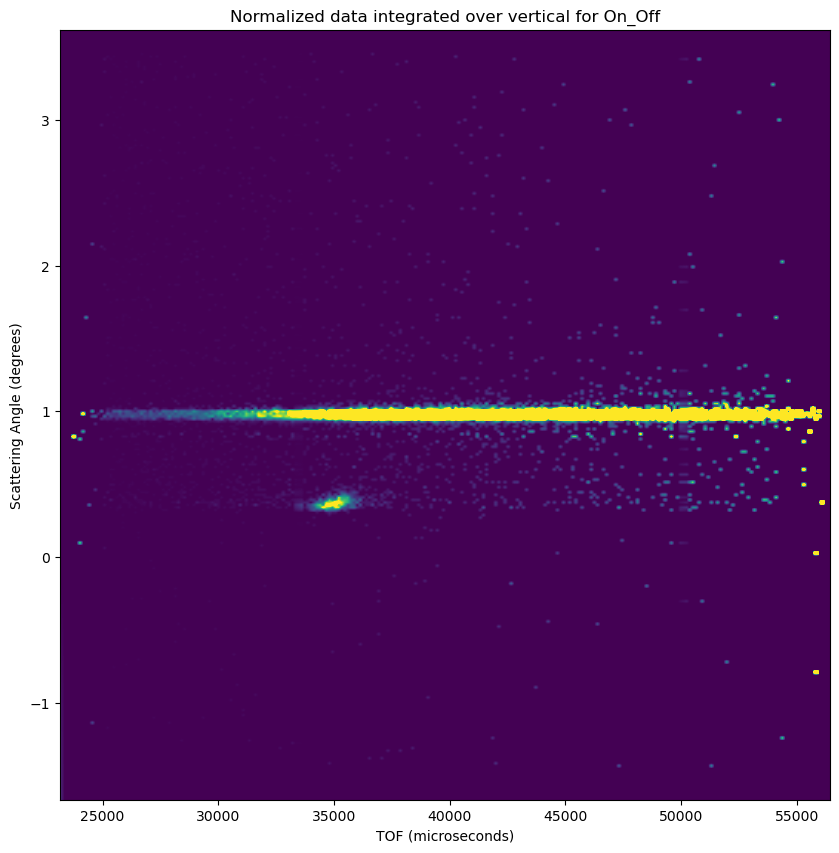

In [151]:

for i in range(4):
    if active_spin_states[i]:
        s_state_descriptor = index_to_state(i)
        plt.figure(figsize = (10,10))
        plt.xlabel('TOF (microseconds)')
        plt.ylabel('Scattering Angle (degrees)')
        plt.title('Normalized data integrated over vertical for '+s_state_descriptor)
        tthmin = two_theta[0]*180/Pi
        tthmax = two_theta[-1]*180/Pi
        plt.imshow(np.transpose(D5_mat[:,:,i],axes=[0,1]), extent=[tof_min,tof_max,tthmin,tthmax], aspect=(tof_max-tof_min)/(tthmax-tthmin), origin='lower',interpolation='bilinear', cmap=cm.viridis, norm=colors.Normalize(vmin=0, vmax=vmax))
        plt.show()


In [152]:
print('B = %s [T]'%b_induction)
print(MAGH)
print(EMagLog_value)

B = 4.8 [T]
True
[0. 0.]
